In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from iminuit import Minuit
from scipy import stats
import sys
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure


In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['figure.figsize'] = (8, 4)

C:\Users\rizfn\AppData\Local\Temp\ipykernel_8924\1128404021.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Q2

In [121]:
data = pd.DataFrame({"drug": [3.7, -1.2, -0.2, 0.7, 0.8], "placebo": [1.5, -1, -0.7, 0.5, 0.1]})
data

,drug,placebo
0,3.7,1.5
1,-1.2,-1.0
2,-0.2,-0.7
3,0.7,0.5
4,0.8,0.1


In [122]:
data.mean(), data.std()

(drug       0.76
 placebo    0.08
 dtype: float64,
 drug       1.831120
 placebo    0.995992
 dtype: float64)

In [123]:
data.std() / len(data)**0.5

drug       0.818902
placebo    0.445421
dtype: float64

In [129]:
stats.ttest_ind(data['drug'], data['placebo'], equal_var=False)

Ttest_indResult(statistic=0.7294558717391544, pvalue=0.4924486548304364)

## Q3

$$\int_0^1 f(x) dx = 1$$
$$\int_0^1 C x^a \sin(\pi x)dx = 1$$
$$\frac1C = \int_0^1x^a\sin(\pi x) dx$$
Integrate by parts

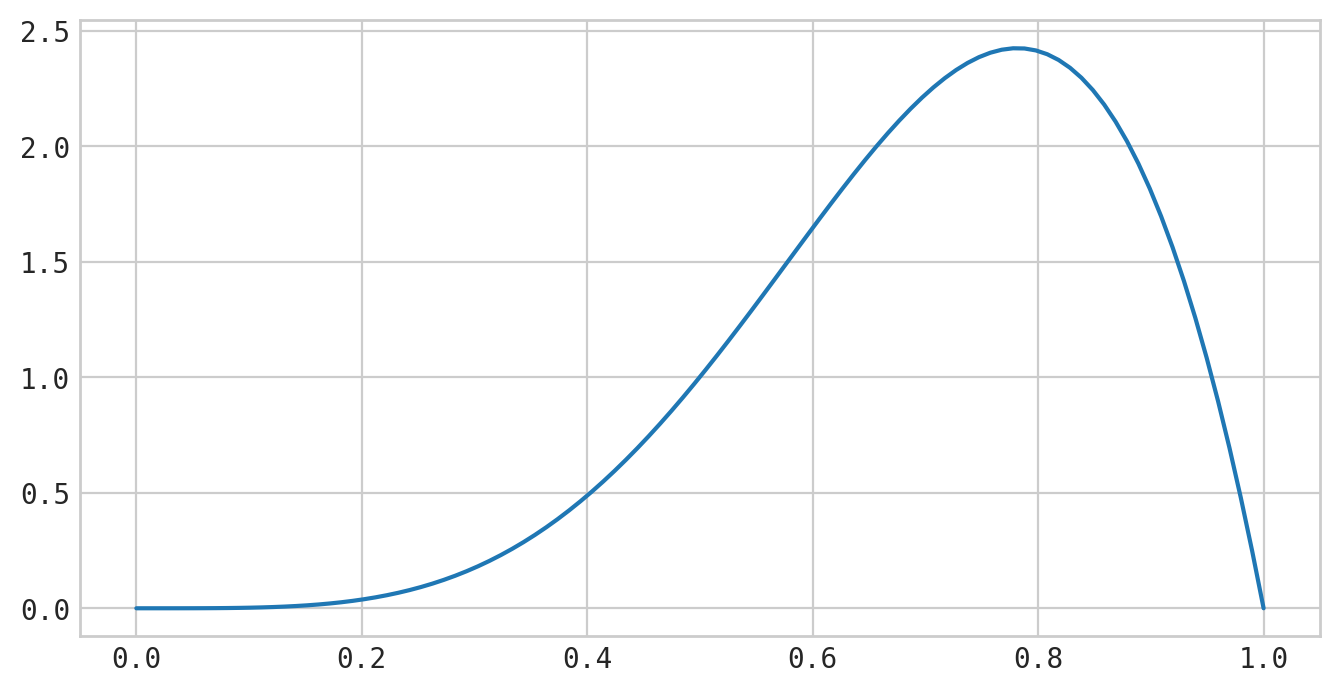

In [3]:
def f(x, C=(np.pi**3 / (np.pi**2 - 6)), a=3):
    return C * x**a * np.sin(np.pi * x)

x = np.linspace(0, 1, 100)
plt.plot(x, f(x))

In [4]:
def bisection_root(f, a, b, tolerance=1e-13):
    '''
    Calculates the root of a function with the bisection method.

    Every step, it bisects the interval to find the new approximate root, and 
    shifts the interval accordingly. Stops iterating when the value of the function
    at the intermediate root is less than the tolerance.

    Args: 
        f (function): A function with a single (float) input
        a (float): The lower end of the initial interval
        b (float): The upper end of the interval. Note that f(a)*f(b) should be negative
        tolerance (float): The tolerance at which the function stops iterating

    Returns:
        x (float): The approximate root of the function, correct to `tolerance`
        n_calls (int): The number of function calls used by the algorithm
    '''
    f_a, n_calls = f(a), 1  # 1 function calls
    f_x = 10*tolerance  # initial
    while np.abs(f_x) > tolerance:
        x = a + (b-a)/2  # bisection step
        f_x = f(x)
        n_calls += 1  # only call the function once each iteration, previous step
        if f_a * f_x > 0:
            a, f_a = x, f_x
        else:
            b = x
    return x, n_calls

In [5]:
def CDF(x, C=(np.pi**3 / (np.pi**2 - 6)), a=3):
    px = np.pi * x
    cos = np.cos(px)
    sin = np.sin(px)
    return -(C*(x**3)*cos)/np.pi + (3*C*(x**2)*sin)/np.pi**2 + (6*C*x*cos)/np.pi**3 - (6*C*sin)/np.pi**4

def inv_CDF(x):
    result = np.zeros_like(x)
    for i, xval in enumerate(x):
        root = bisection_root(lambda l: CDF(l) - xval, 0, 1)[0]
        result[i] = root
    return result

# def inv_CDF(x):  # todo: vectorize bisection
#     root = bisection_root(lambda l: CDF(l) - x, 0, 1)[0]
#     return root

def inverse_transform_sample(inv_CDF, n_samples):
    r = np.random.rand(n_samples)
    return inv_CDF(r)

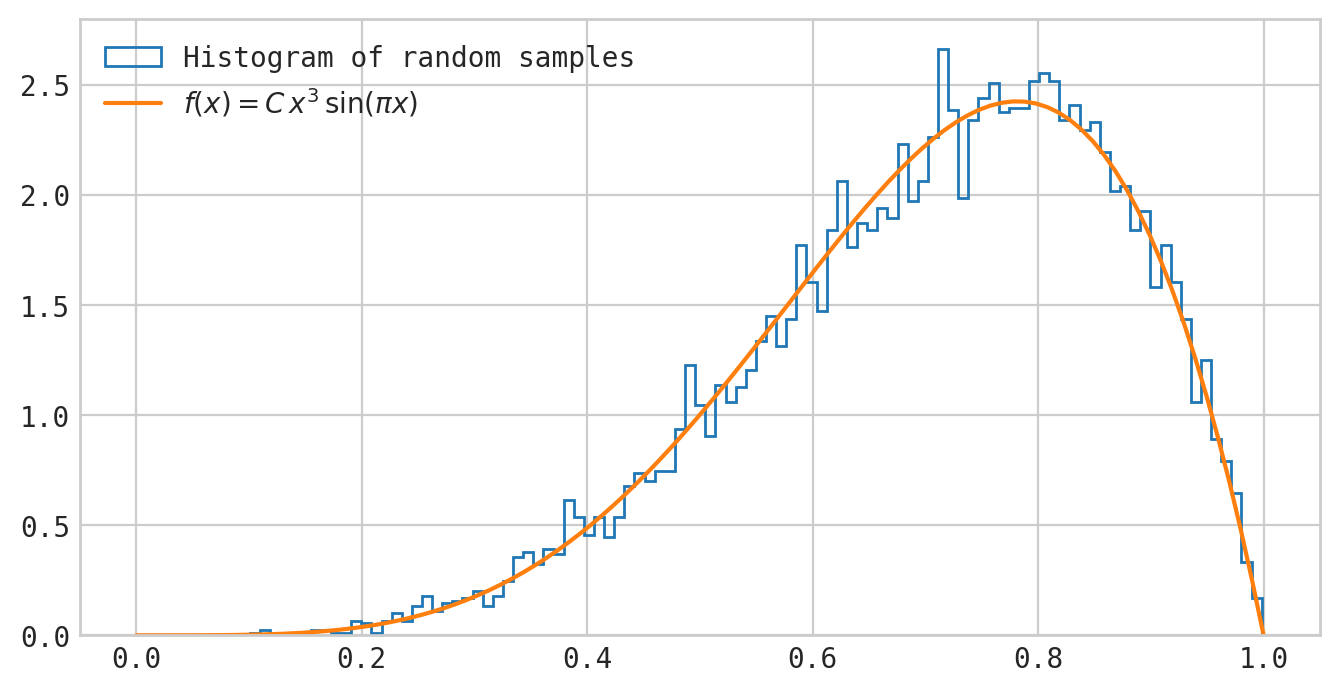

In [6]:
plt.hist(inverse_transform_sample(inv_CDF, 10000), bins=100, density=True, label='Histogram of random samples', histtype='step')
plt.plot(x, f(x), label=r'$f(x) = C \, x^3 \, \sin(\pi x)$')
plt.legend()

In [63]:
def fit_a(x, a, C):
    return C * x**a * np.sin(np.pi * x)


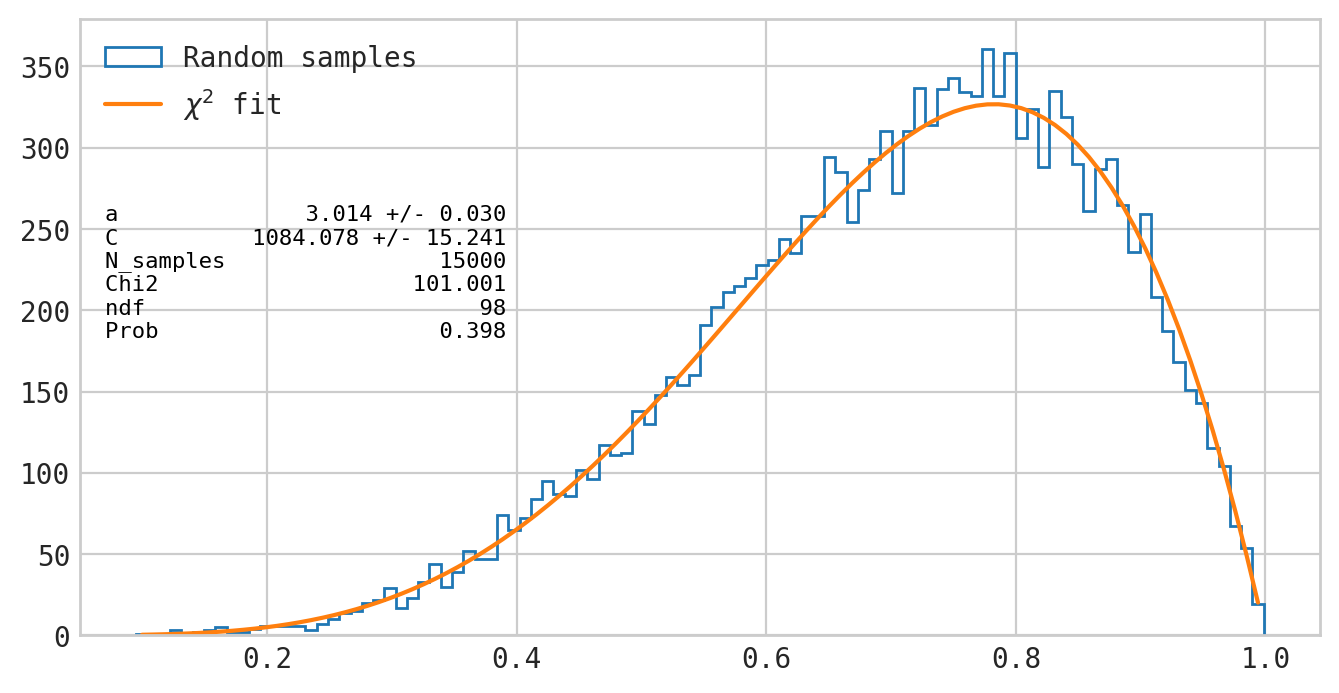

In [79]:
Nbins = 100
N_samples = 15000

data = inverse_transform_sample(inv_CDF, N_samples)
# y, x_edges = np.histogram(data, bins=Nbins, density=True)
y, x_edges = np.histogram(data, bins=Nbins)

x = (x_edges[1:] + x_edges[:-1])/2

chi2_object = Chi2Regression(fit_a, x[y>0], y[y>0], np.sqrt(y)[y>0])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

minuit = Minuit(chi2_object, a=3, C=0.1)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 2                    # Number of variables (a, C)
Ndof_fit = Nbins - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
plt.hist(data, bins=Nbins, histtype='step', label='Random samples')
plt.plot(x, fit_a(x, minuit.values['a'], minuit.values['C']), label=r'$\chi^2$ fit')
plt.legend()

d = {'a': [minuit.values['a'], minuit.errors['a']],
     'C': [minuit.values['C'], minuit.errors['C']],
     'N_samples' : N_samples,
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.7, text, ax, fontsize=8)


## Q4

### 4.1

In [111]:
dataframe = pd.read_csv('data_GripStrength.csv')
domhand, dom_grip, ndom_grip = dataframe.values.T
dataframe

,DominantHand,DominantGrip(N),NonDominantGrip(N)
0,1.0,293.24,241.50
1,1.0,547.39,552.01
2,0.0,578.85,495.98
3,1.0,342.30,342.18
4,1.0,337.79,347.14
...,...,...,...
79,1.0,335.67,305.39
80,1.0,362.91,336.60
81,1.0,659.39,623.32
82,1.0,292.84,254.46


In [112]:
dataframe['DominantHand'].value_counts()

1.0    68
0.0    16
Name: DominantHand, dtype: int64

There are 68/84 = 0.8095238095238095 right handed people

In [113]:
pd.DataFrame([dataframe[[' DominantGrip(N)', ' NonDominantGrip(N)']].mean(), dataframe[[' DominantGrip(N)', ' NonDominantGrip(N)']].std()])

,DominantGrip(N),NonDominantGrip(N)
0,444.930952,418.481786
1,145.008678,138.217645


In [114]:
mu1, mu2 = dataframe[[' DominantGrip(N)', ' NonDominantGrip(N)']].mean()
sigma1, sigma2 = dataframe[[' DominantGrip(N)', ' NonDominantGrip(N)']].std()

n1 = len(dataframe[' DominantGrip(N)'])
n2 = len(dataframe[' NonDominantGrip(N)'])

s = (((n1-1)*sigma1**2 + (n2-1)*sigma2**2)/(n1 + n2 - 2))**0.5

d = (mu1 - mu2) / s
d

0.18671687478380875

In [115]:
corr = dataframe.corr()[' DominantGrip(N)'][2]
d / (1 - corr)**0.5

1.3159194248406767

In [116]:
dataframe['GripDifference(N)'] = dataframe[' DominantGrip(N)'] - dataframe[' NonDominantGrip(N)']
dataframe['GripDifference(N)'].mean(), dataframe['GripDifference(N)'].std()

(26.449166666666674, 29.20890111107342)

There is no statistically significant difference in grip strength, because the mean is less than 1 $\sigma$ away from 0, which implies there's a probability of $>30%$ that the mean isn't non-zero (QUANTIFY)

In [119]:
data = [dataframe[' DominantGrip(N)'], dataframe[' NonDominantGrip(N)']]
stats.wilcoxon(*data)

WilcoxonResult(statistic=338.0, pvalue=1.0944213578371819e-10)

### 4.2

In [80]:
dataframe = pd.read_csv('data_MoleculeTypes.csv', names=['Size', 'Intensity'])
dataframe

,Size,Intensity
0,45.267,0.800
1,43.549,0.736
2,41.326,0.390
3,26.767,0.281
4,24.066,0.220
...,...,...
981,44.660,0.576
982,41.076,0.744
983,42.454,0.657
984,53.994,0.698


In [180]:
def gaussian(x, A, mu, sigma):
    return A * (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-(x-mu)**2 / (2*sigma**2))

def two_gaussian_fit(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return gaussian(x, A1, mu1, sigma1) + gaussian(x, A2, mu2, sigma2)


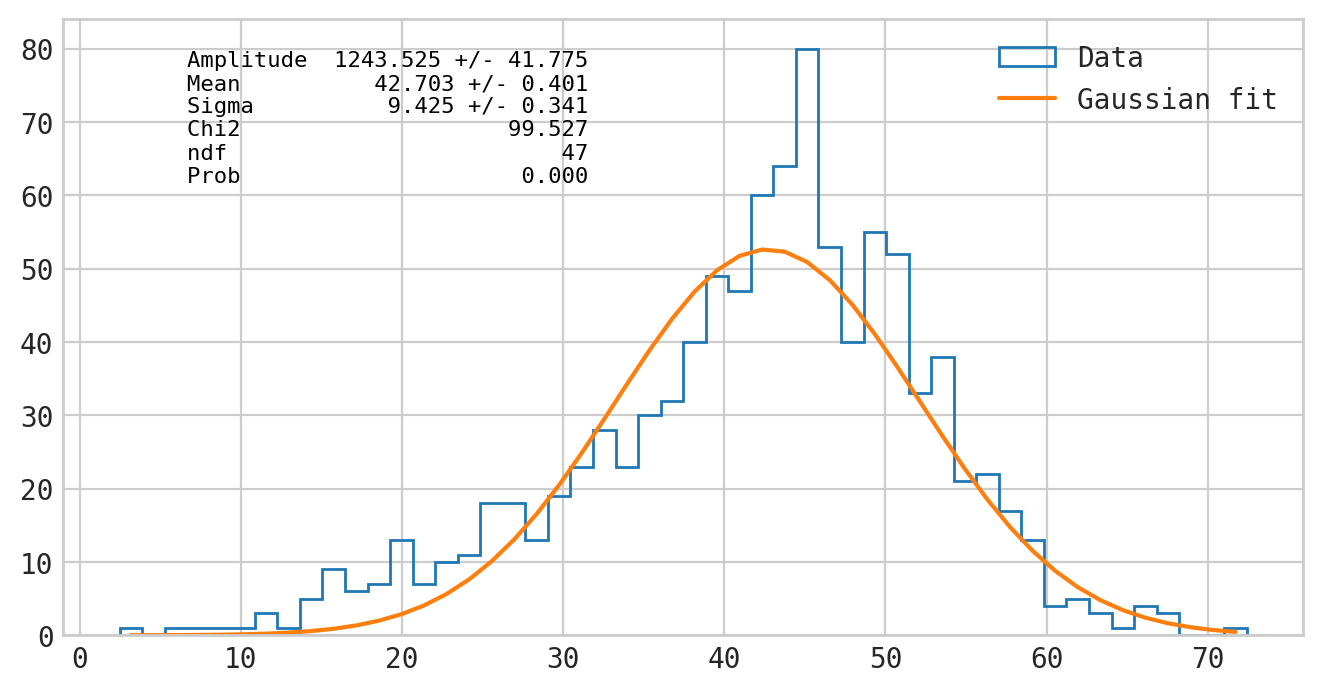

In [35]:
Nbins = 50

y, x_edges = np.histogram(dataframe['Size'], bins=Nbins)

# y, x_edges = np.histogram(np.random.normal(40,9,10000), bins=Nbins, density=True)
x = (x_edges[1:] + x_edges[:-1])/2

# Now we define a ChiSquare to be minimised (using ExternalFunctions):
chi2_object = Chi2Regression(gaussian, x[y>0], y[y>0], np.sqrt(y)[y>0])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit = Minuit(chi2_object, A=100, mu=45, sigma=10)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 3                    # Number of variables (alpha0 and alpha1)
Ndof_fit = Nbins - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
# plt.errorbar(x, y, np.sqrt(y), label='Binned data')
plt.hist(dataframe['Size'], bins=Nbins, histtype='step', label='Data')
plt.plot(x, gaussian(x, minuit.values['A'], minuit.values['mu'], minuit.values['sigma']), label=f'Gaussian fit')
plt.legend()

d = {'Amplitude': [minuit.values['A'], minuit.errors['A']],
     'Mean': [minuit.values['mu'], minuit.errors['mu']],
     'Sigma': [minuit.values['sigma'], minuit.errors['sigma']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.1, 0.95, text, ax, fontsize=8)


Do a chi^2 or another test to see if it's gausian

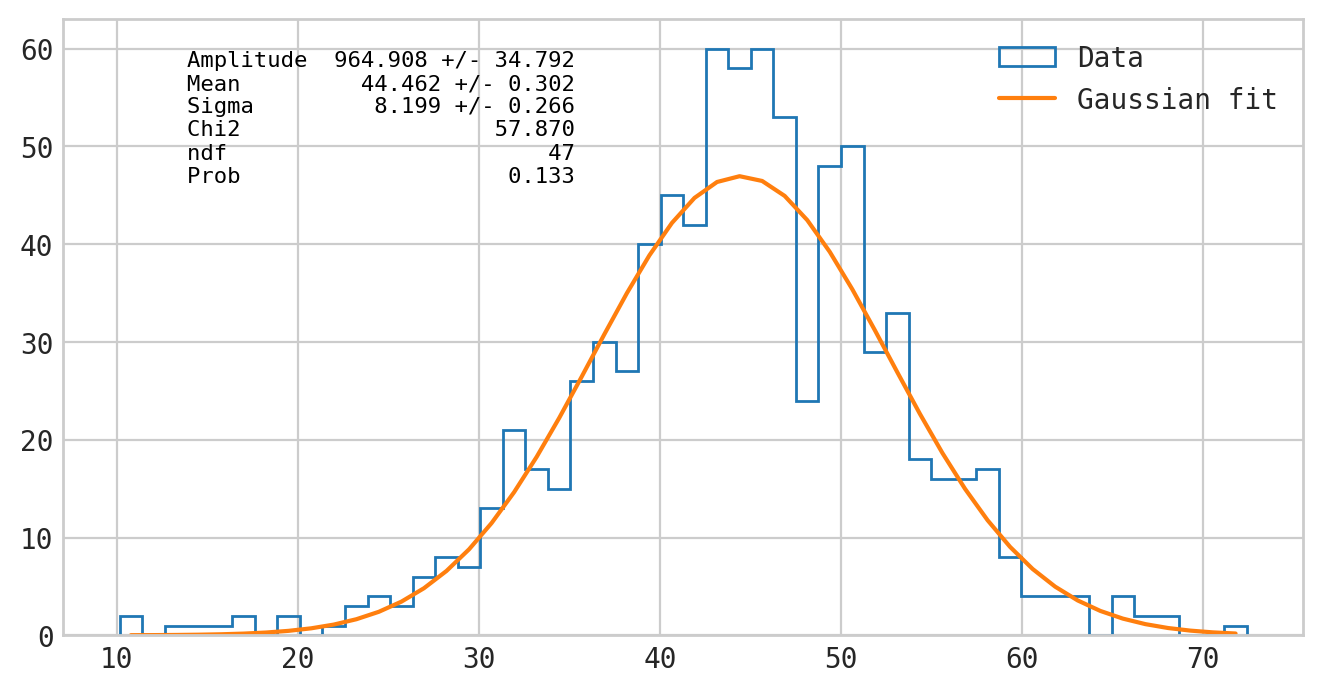

In [36]:
Nbins = 50

y, x_edges = np.histogram(dataframe[dataframe['Intensity'] > 0.5]['Size'], bins=Nbins)

# y, x_edges = np.histogram(np.random.normal(40,9,10000), bins=Nbins, density=True)
x = (x_edges[1:] + x_edges[:-1])/2

# Now we define a ChiSquare to be minimised (using ExternalFunctions):
chi2_object = Chi2Regression(gaussian, x[y>0], y[y>0], np.sqrt(y)[y>0])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit = Minuit(chi2_object, A=100, mu=45, sigma=10)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 3                    # Number of variables (A, mu, sigma)
Ndof_fit = Nbins - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
# plt.errorbar(x, y, np.sqrt(y), label='Binned data')
plt.hist(dataframe[dataframe['Intensity'] > 0.5]['Size'], bins=Nbins, histtype='step', label='Data')
plt.plot(x, gaussian(x, minuit.values['A'], minuit.values['mu'], minuit.values['sigma']), label=f'Gaussian fit')
plt.legend()

d = {'Amplitude': [minuit.values['A'], minuit.errors['A']],
     'Mean': [minuit.values['mu'], minuit.errors['mu']],
     'Sigma': [minuit.values['sigma'], minuit.errors['sigma']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.1, 0.95, text, ax, fontsize=8)


Double gaussian fit:


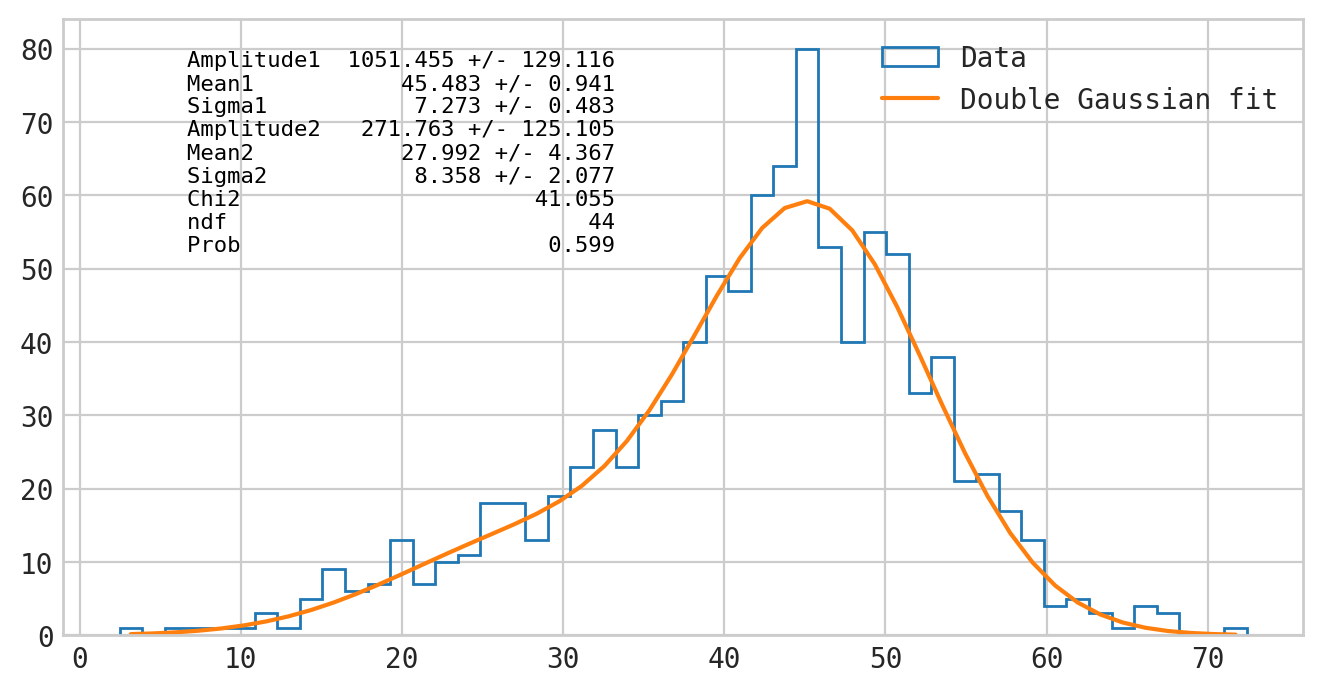

In [278]:
Nbins = 50

y, x_edges = np.histogram(dataframe['Size'], bins=Nbins)

# y, x_edges = np.histogram(np.random.normal(40,9,10000), bins=Nbins, density=True)
x = (x_edges[1:] + x_edges[:-1])/2

# Now we define a ChiSquare to be minimised (using ExternalFunctions):
chi2_object = Chi2Regression(two_gaussian_fit, x[y>0], y[y>0], np.sqrt(y)[y>0])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit = Minuit(chi2_object, A1=1000, mu1=45, sigma1=8.2, A2=100, mu2=28, sigma2=10)     # External Functions

# Perform the actual fit:
minuit.migrad()


Nvar = 6                    # Number of variables (A, mu, sigma)
Ndof_fit = Nbins - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
# plt.errorbar(x, y, np.sqrt(y), label='Binned data')
plt.hist(dataframe['Size'], bins=Nbins, histtype='step', label='Data')
plt.plot(x, two_gaussian_fit(x, minuit.values['A1'], minuit.values['mu1'], minuit.values['sigma1'],
         minuit.values['A2'], minuit.values['mu2'], minuit.values['sigma2']), label=f'Double Gaussian fit')
plt.legend()

d = {'Amplitude1': [minuit.values['A1'], minuit.errors['A1']],
     'Mean1': [minuit.values['mu1'], minuit.errors['mu1']],
     'Sigma1': [minuit.values['sigma1'], minuit.errors['sigma1']],
     'Amplitude2': [minuit.values['A2'], minuit.errors['A2']],
     'Mean2': [minuit.values['mu2'], minuit.errors['mu2']],
     'Sigma2': [minuit.values['sigma2'], minuit.errors['sigma2']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.1, 0.95, text, ax, fontsize=8)


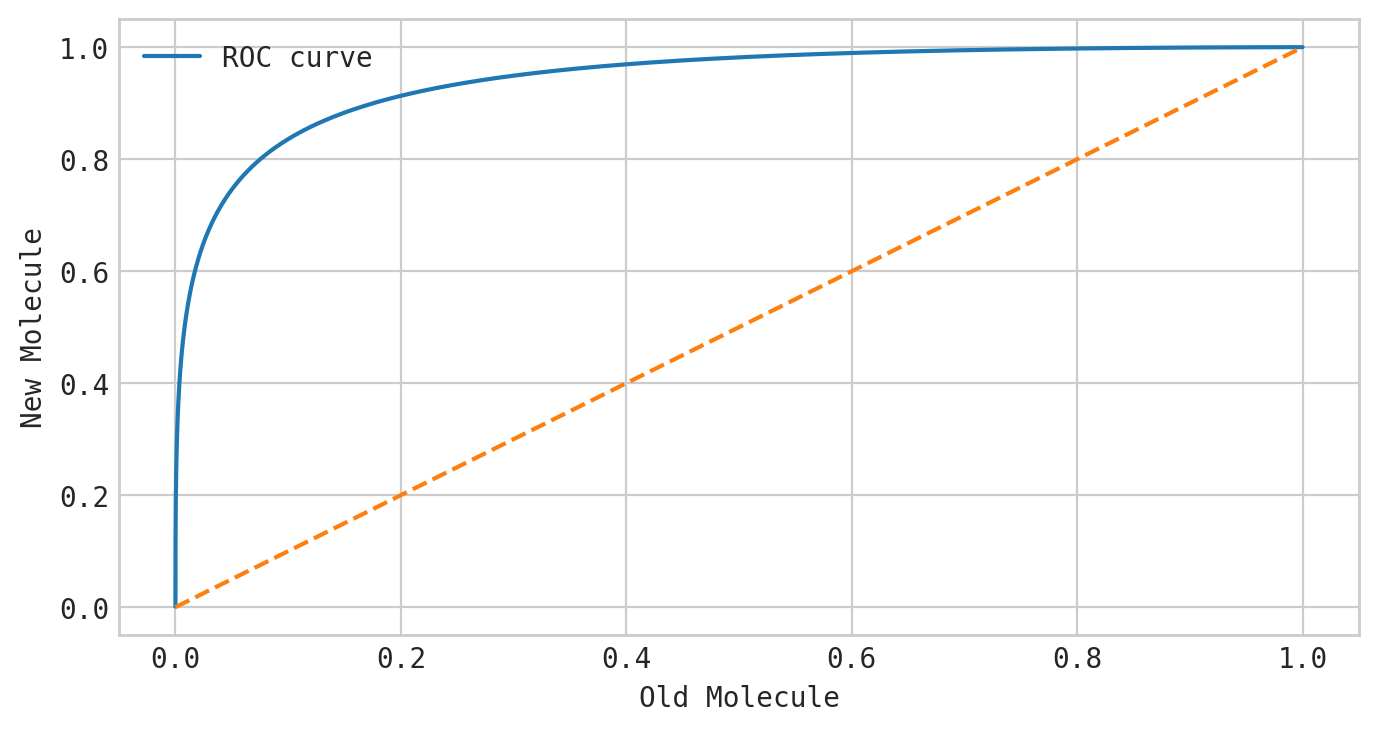

In [89]:
x = np.linspace(dataframe['Size'].min(), dataframe['Size'].max(), 1000)
new_molecule = stats.norm.cdf(x, loc=27.992, scale=8.358)
old_molecule = stats.norm.cdf(x, loc=45.483, scale=7.273)
plt.plot(old_molecule, new_molecule, label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Old Molecule')
plt.ylabel('New Molecule')
plt.legend();

35.74127927927928
35.81128828828829


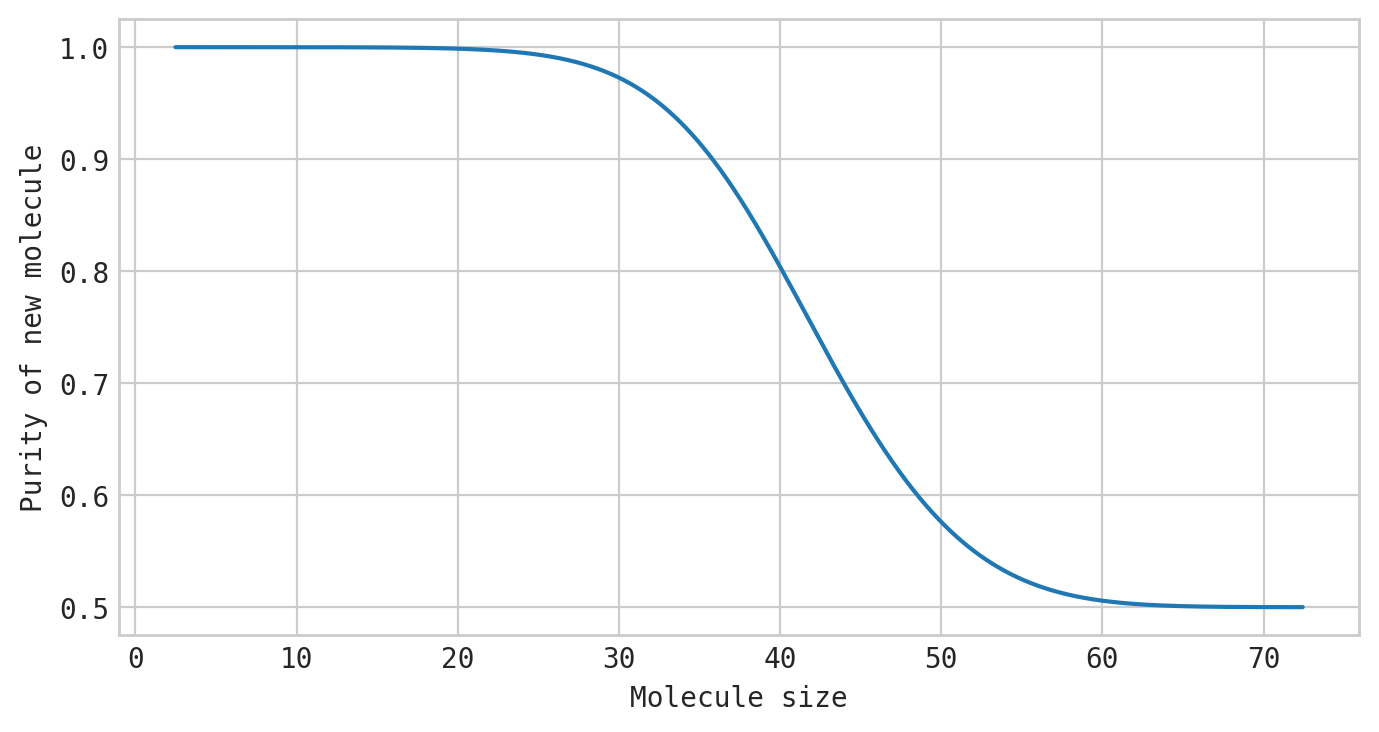

In [105]:
new_percent = new_molecule / (new_molecule+old_molecule)
print(x[new_percent > 0.9][-1])
print(x[new_percent < 0.9][0])
plt.plot(x, new_percent)
plt.xlabel('Molecule size')
plt.ylabel('Purity of new molecule');

In [109]:
dataframe[dataframe['Size'] < 35.75]

,Size,Intensity
929,2.487,0.275
194,6.464,0.384
45,7.278,0.316
937,8.730,0.389
207,10.147,0.588
...,...,...
513,35.468,0.618
438,35.472,0.761
42,35.546,0.629
130,35.550,0.537


30.070549549549554
30.14055855855856


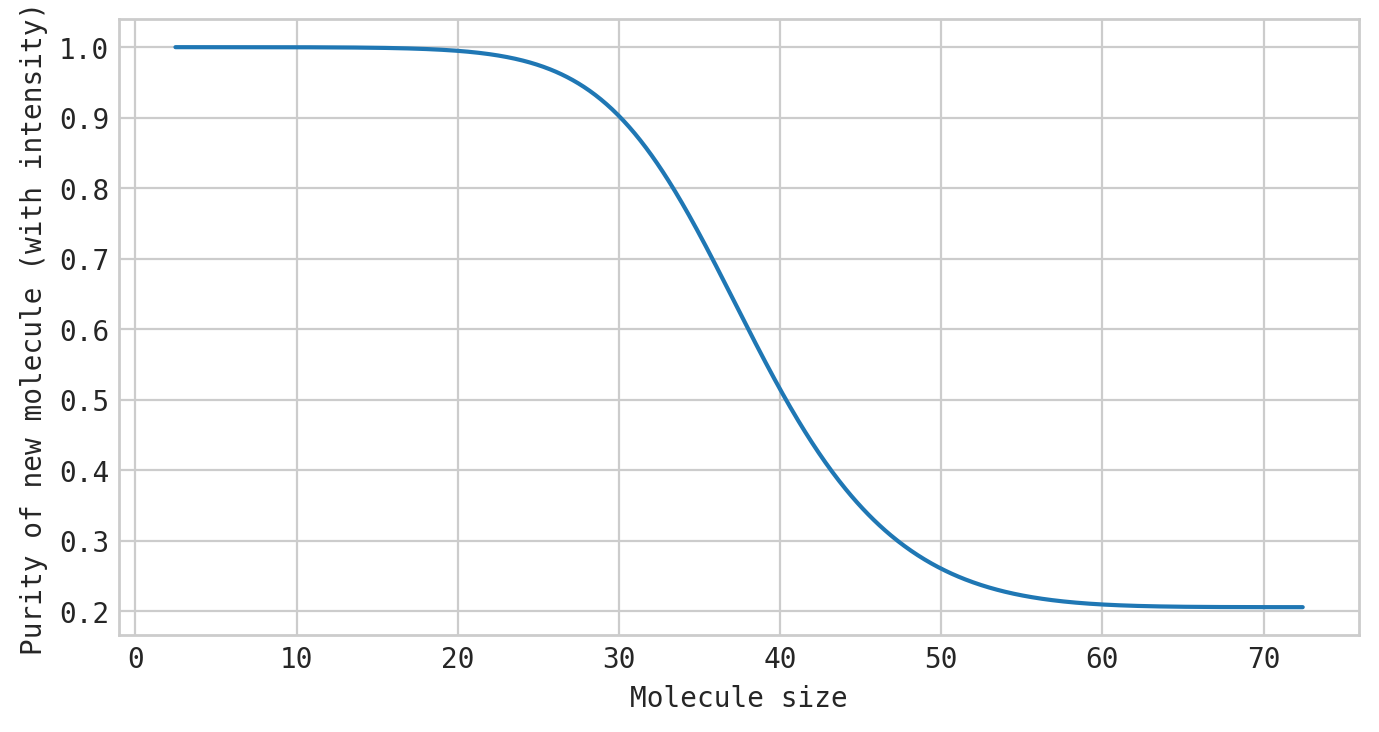

In [107]:
new_molecule_I = 271.919*stats.norm.cdf(x, loc=27.992, scale=8.358)
old_molecule_I = 1051.318*stats.norm.cdf(x, loc=45.483, scale=7.273)

new_percent_I = new_molecule_I / (new_molecule_I+old_molecule_I)
print(x[new_percent_I > 0.9][-1])
print(x[new_percent_I < 0.9][0])
plt.plot(x, new_percent_I)
plt.xlabel('Molecule size')
plt.ylabel('Purity of new molecule (with intensity)');

In [110]:
dataframe[dataframe['Size'] < 30.10]

,Size,Intensity
3,26.767,0.281
4,24.066,0.220
6,27.078,0.655
13,18.846,0.343
18,25.161,0.384
...,...,...
936,27.113,0.641
937,8.730,0.389
941,28.680,0.350
942,25.803,0.364


## Q5

### 5.1

In [132]:
dataframe = pd.read_csv('data_AlgaeGrowth.csv', names=['Time', 'Area', 'AreaUncertainity'])
dataframe

,Time,Area,AreaUncertainity
0,0.35,1470.40,45.0
1,0.57,1426.93,45.0
2,0.60,1466.84,45.0
3,0.90,1580.44,45.0
4,1.08,1626.27,45.0
...,...,...,...
85,11.71,1974.83,45.0
86,11.85,2044.98,45.0
87,11.93,2059.38,45.0
88,12.26,2014.04,45.0


<ErrorbarContainer object of 3 artists>

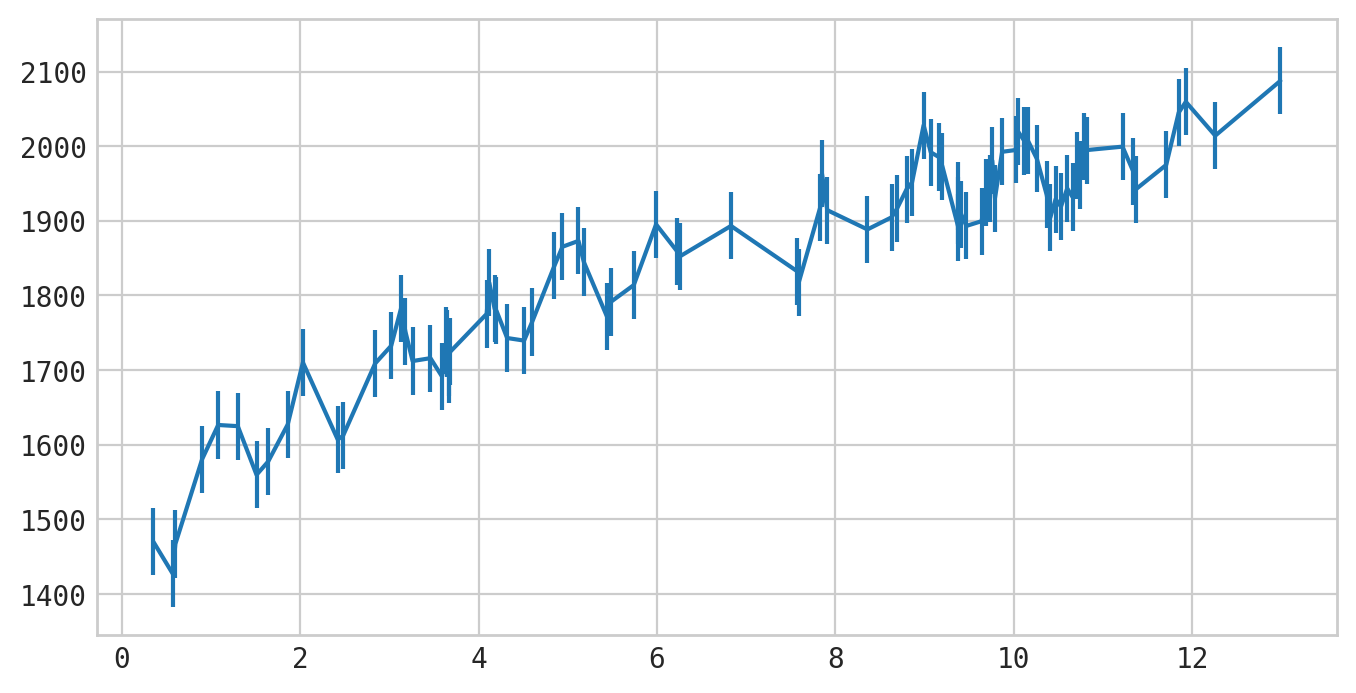

In [133]:
plt.errorbar(dataframe['Time'], dataframe['Area'], dataframe['AreaUncertainity'])

In [134]:
def deg3_poly(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d


def day_night_corrected_fit(x, a, b, c, d, amp, freq, shift):
    return amp * np.sin(x*freq + shift) + deg3_poly(x, a, b, c, d)


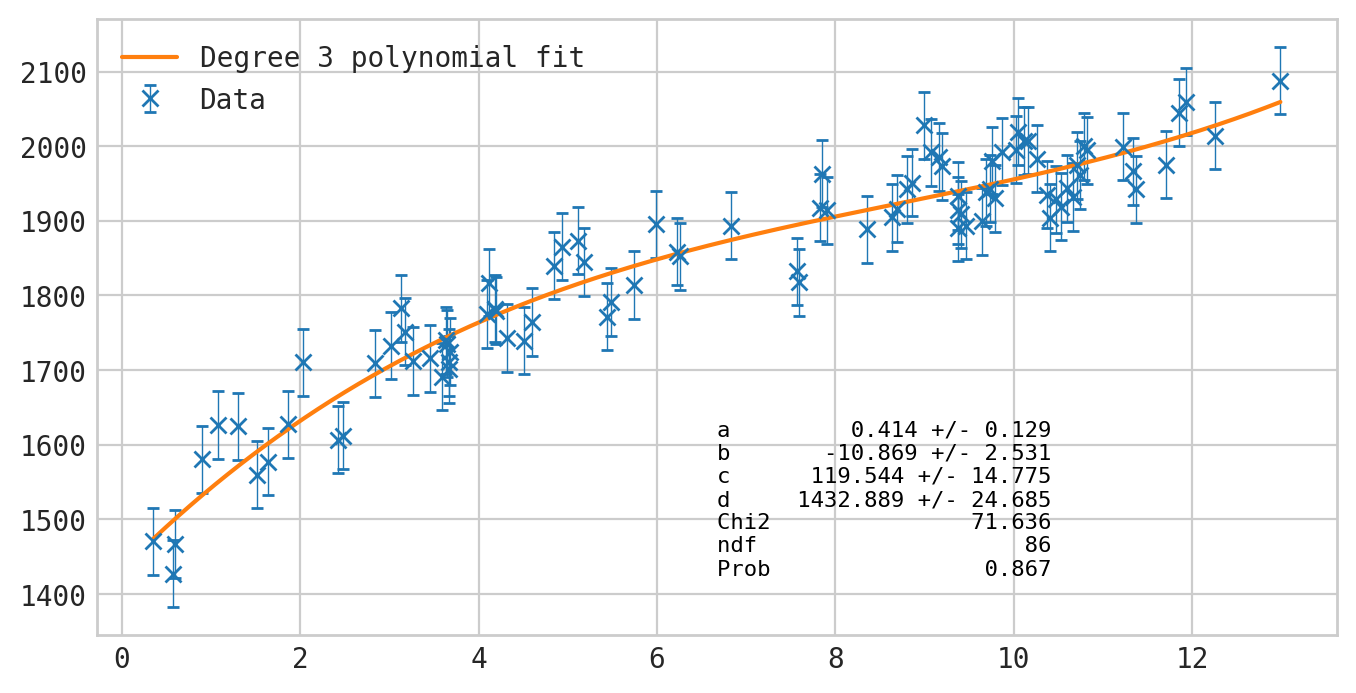

In [135]:
# Now we define a ChiSquare to be minimised (using ExternalFunctions):
chi2_object = Chi2Regression(deg3_poly, dataframe['Time'], dataframe['Area'], dataframe['AreaUncertainity'])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit = Minuit(chi2_object, a=1, b=1, c=1, d=1400)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 4                   # Number of variables (a, b, c, d)
Ndof_fit = len(dataframe) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
plt.errorbar(dataframe['Time'], dataframe['Area'], dataframe['AreaUncertainity'], label='Data', capsize=2, elinewidth=0.5, fmt='x ')
x = np.linspace(min(dataframe['Time']), max(dataframe['Time']), 1000)
plt.plot(x, deg3_poly(x, minuit.values['a'], minuit.values['b'], minuit.values['c'], minuit.values['d']), label=f'Degree 3 polynomial fit')
plt.legend()

d = {'a': [minuit.values['a'], minuit.errors['a']],
     'b': [minuit.values['b'], minuit.errors['b']],
     'c': [minuit.values['c'], minuit.errors['c']],
     'd': [minuit.values['d'], minuit.errors['d']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.5, 0.35, text, ax, fontsize=8)


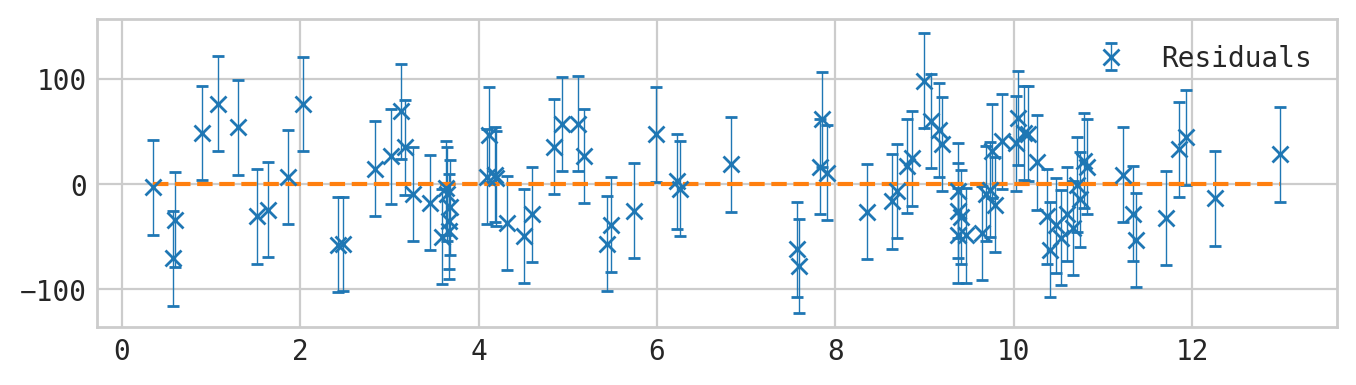

In [152]:
residuals = dataframe['Area']-deg3_poly(dataframe['Time'], minuit.values['a'], minuit.values['b'], minuit.values['c'], minuit.values['d'])
plt.figure(figsize=[8, 2])
plt.errorbar(dataframe['Time'], residuals, dataframe['AreaUncertainity'], capsize=2, elinewidth=0.5, fmt='x ', label='Residuals')
plt.plot(dataframe['Time'], 0*dataframe['Time'], linestyle='--')
plt.legend();

Runs test

In [150]:
def WaldWolfowitzRuns(L):
  def getRuns(l):
    import itertools
    return len([sum(1 for _ in r) for _, r in itertools.groupby(l)])

  def WW_runs_test(R, n1, n2, n):
      # compute the standard error of R if the null (random) is true
      seR = np.sqrt( ((2*n1*n2) * (2*n1*n2 - n)) / ((n**2)*(n-1)) )

      # compute the expected value of R if the null is true
      muR = ((2*n1*n2)/n) + 1

      # test statistic: R vs muR
      z = (R - muR) / seR

      return z


  # Gather info 
  numRuns = getRuns(L) # Grab streaks in the data

  # Define parameters
  R = numRuns      # number of runs
  n1 = sum(L)      # number of 1's
  n2 = len(L) - n1 # number of 0's
  n = n1 + n2      # should equal len(L)

  # Run the test
  ww_z = WW_runs_test(R, n1, n2, n)

  # test the pvalue
  p_values_one = stats.norm.sf(abs(ww_z))   #one-sided
  p_values_two = stats.norm.sf(abs(ww_z))*2 #twosided

  # Print results
  print('Wald-Wolfowitz Runs Test')
  print('Number of runs: %s' %(R))
  print('Number of 1\'s: %s; Number of 0\'s: %s ' %(n1,n2))
  print('Z value: %s' %(ww_z))
  print('One tailed P value: %s; Two tailed P value: %s ' %(p_values_one, p_values_two))

In [151]:
WaldWolfowitzRuns(residuals>0)

Wald-Wolfowitz Runs Test
Number of runs: 28
Number of 1's: 42; Number of 0's: 48 
Z value: -3.790870453235762
One tailed P value: 7.506012176351845e-05; Two tailed P value: 0.0001501202435270369 


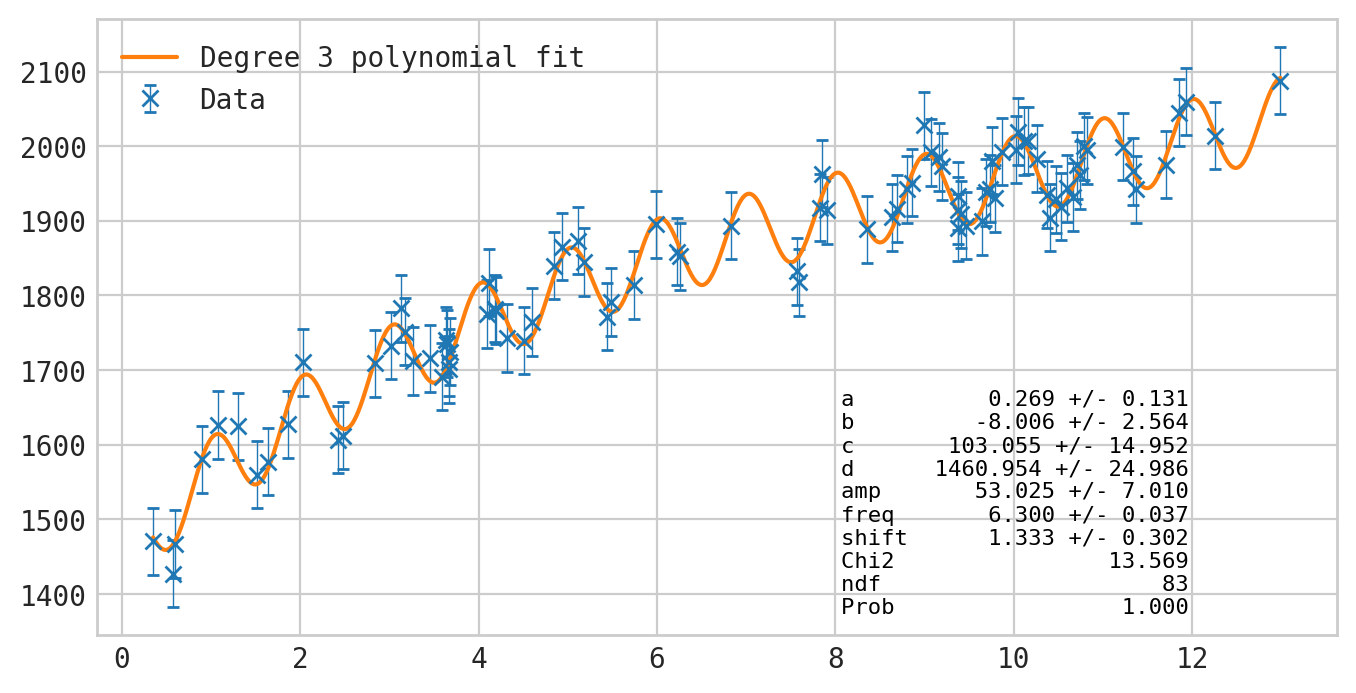

In [153]:
# Now we define a ChiSquare to be minimised (using ExternalFunctions):
chi2_object = Chi2Regression(day_night_corrected_fit, dataframe['Time'], dataframe['Area'], dataframe['AreaUncertainity'])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit = Minuit(chi2_object, a=0.4, b=-10, c=120, d=1400, amp=53, freq=6.3, shift=1.3)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 7                   # Number of variables (a, b, c, d, amp, freq, shift)
Ndof_fit = len(dataframe) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
x = np.linspace(min(dataframe['Time']), max(dataframe['Time']), 1000)
plt.errorbar(dataframe['Time'], dataframe['Area'], dataframe['AreaUncertainity'], label='Data', capsize=2, elinewidth=0.5, fmt='x ')
plt.plot(x, day_night_corrected_fit(x, minuit.values['a'], minuit.values['b'], minuit.values['c'], minuit.values['d'], minuit.values['amp'], minuit.values['freq'], minuit.values['shift']), label=f'Degree 3 polynomial fit')
plt.legend()

d = {'a': [minuit.values['a'], minuit.errors['a']],
     'b': [minuit.values['b'], minuit.errors['b']],
     'c': [minuit.values['c'], minuit.errors['c']],
     'd': [minuit.values['d'], minuit.errors['d']],
     'amp': [minuit.values['amp'], minuit.errors['amp']],
     'freq': [minuit.values['freq'], minuit.errors['freq']],
     'shift': [minuit.values['shift'], minuit.errors['shift']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.6, 0.4, text, ax, fontsize=8)


Wald-Wolfowitz Runs Test
Number of runs: 45
Number of 1's: 43; Number of 0's: 47 
Z value: -0.1935540366576299
One tailed P value: 0.42326254545730546; Two tailed P value: 0.8465250909146109 


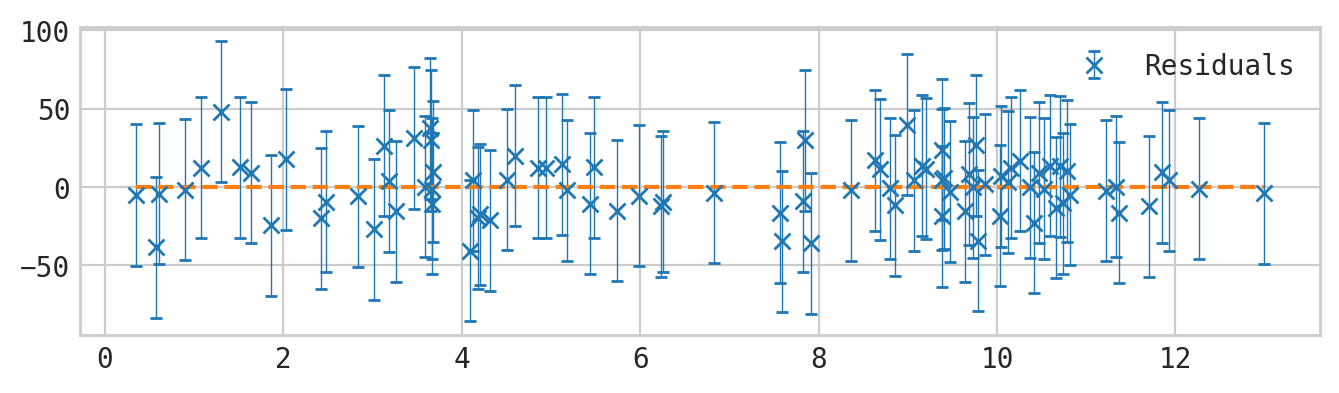

In [157]:
residuals = dataframe['Area']-day_night_corrected_fit(dataframe['Time'], minuit.values['a'], minuit.values['b'], minuit.values['c'], minuit.values['d'], minuit.values['amp'], minuit.values['freq'], minuit.values['shift'])
plt.figure(figsize=[8, 2])
plt.errorbar(dataframe['Time'], residuals, dataframe['AreaUncertainity'], capsize=2, elinewidth=0.5, fmt='x ', label='Residuals')
plt.plot(dataframe['Time'], 0*dataframe['Time'], linestyle='--')
plt.legend()
WaldWolfowitzRuns(residuals>0)

error / 2.4635

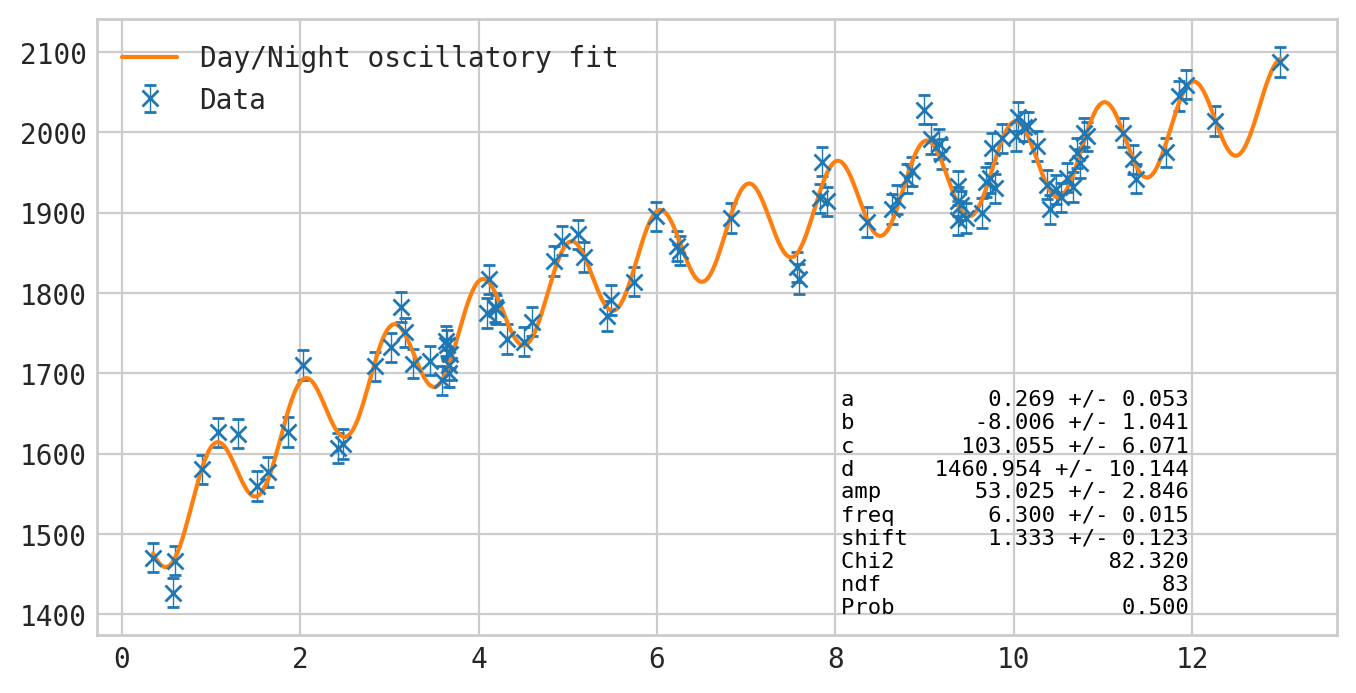

In [164]:
# Now we define a ChiSquare to be minimised (using ExternalFunctions):
chi2_object = Chi2Regression(day_night_corrected_fit, dataframe['Time'], dataframe['Area'], dataframe['AreaUncertainity']*0.406)
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit = Minuit(chi2_object, a=0.4, b=-10, c=120, d=1400, amp=53, freq=6.3, shift=1.3)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 7                   # Number of variables (a, b, c, d, amp, freq, shift)
Ndof_fit = len(dataframe) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
x = np.linspace(min(dataframe['Time']), max(dataframe['Time']), 1000)
plt.errorbar(dataframe['Time'], dataframe['Area'], dataframe['AreaUncertainity']*0.406, label='Data', capsize=2, elinewidth=0.5, fmt='x ')
plt.plot(x, day_night_corrected_fit(x, minuit.values['a'], minuit.values['b'], minuit.values['c'], minuit.values['d'], minuit.values['amp'], minuit.values['freq'], minuit.values['shift']), label=f'Day/Night oscillatory fit')
plt.legend()

d = {'a': [minuit.values['a'], minuit.errors['a']],
     'b': [minuit.values['b'], minuit.errors['b']],
     'c': [minuit.values['c'], minuit.errors['c']],
     'd': [minuit.values['d'], minuit.errors['d']],
     'amp': [minuit.values['amp'], minuit.errors['amp']],
     'freq': [minuit.values['freq'], minuit.errors['freq']],
     'shift': [minuit.values['shift'], minuit.errors['shift']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.6, 0.4, text, ax, fontsize=8)


Wald-Wolfowitz Runs Test
Number of runs: 45
Number of 1's: 43; Number of 0's: 47 
Z value: -0.1935540366576299
One tailed P value: 0.42326254545730546; Two tailed P value: 0.8465250909146109 


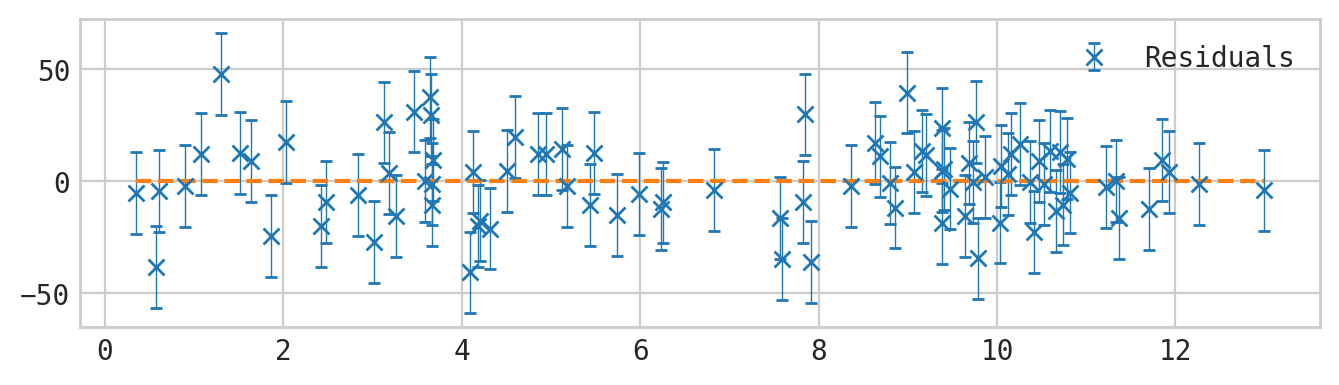

In [163]:
residuals = dataframe['Area']-day_night_corrected_fit(dataframe['Time'], minuit.values['a'], minuit.values['b'], minuit.values['c'], minuit.values['d'], minuit.values['amp'], minuit.values['freq'], minuit.values['shift'])
plt.figure(figsize=[8, 2])
plt.errorbar(dataframe['Time'], residuals, dataframe['AreaUncertainity']*0.406, capsize=2, elinewidth=0.5, fmt='x ', label='Residuals')
plt.plot(dataframe['Time'], 0*dataframe['Time'], linestyle='--')
plt.legend()
WaldWolfowitzRuns(residuals>0)

### 5.2

In [165]:
dataframe = pd.read_csv('data_BohrHypothesis.csv', names=['Wavelength', 'Voltage'])
dataframe

,Wavelength,Voltage
0,2439.703,134.833
1,1276.206,102.063
2,1665.593,98.818
3,1868.467,123.123
4,2075.338,103.849
...,...,...
216540,1761.204,137.935
216541,1748.524,153.508
216542,1555.461,76.994
216543,1367.070,87.436


<AxesSubplot: >

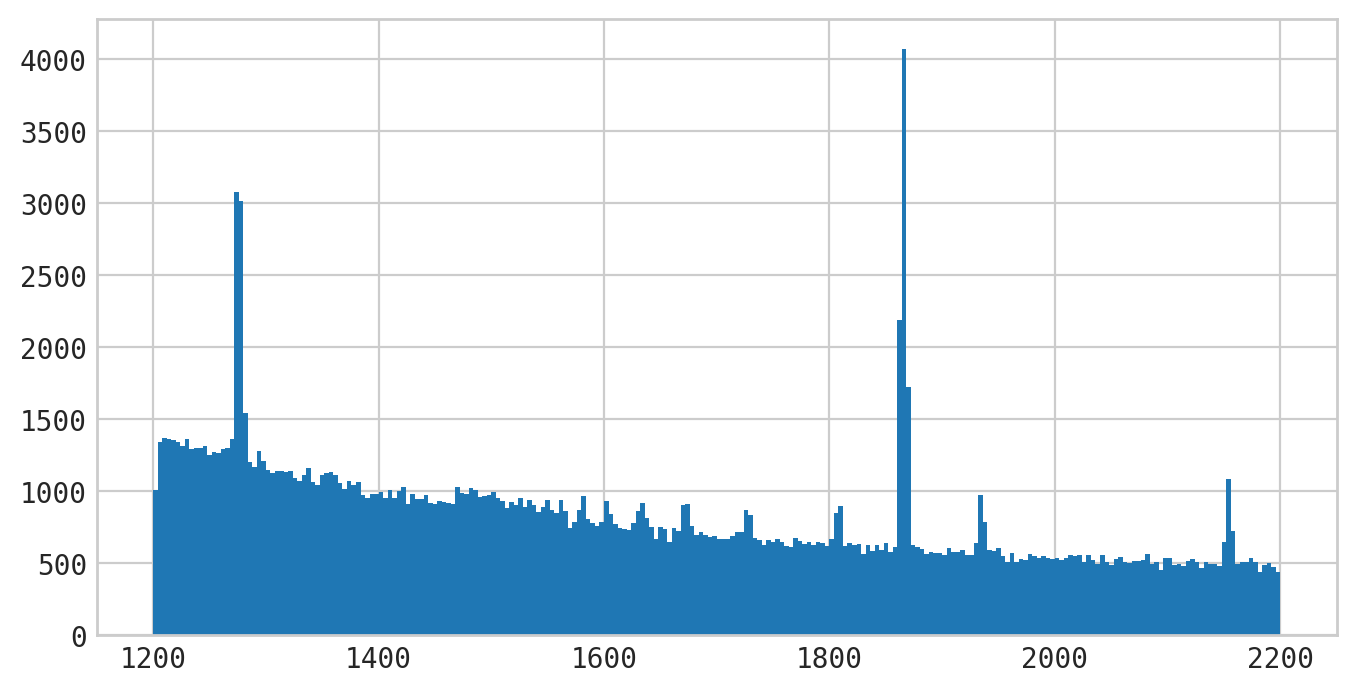

In [179]:
dataframe[(1200 < dataframe['Wavelength']) & (dataframe['Wavelength'] < 2200)]['Wavelength'].hist(bins=250)

In [229]:
def fit_2_peaks(x, expAmp, expDecay, amp1, mu1, sigma1, amp2, mu2, sigma2):
    return expAmp*np.exp(-expDecay*x) + two_gaussian_fit(x, amp1, mu1, sigma1, amp2, mu2, sigma2)

def fit_1_peak(x, expAmp, expDecay, amp, mu, sigma):
    return expAmp*np.exp(-expDecay*x) + gaussian(x, amp, mu, sigma)

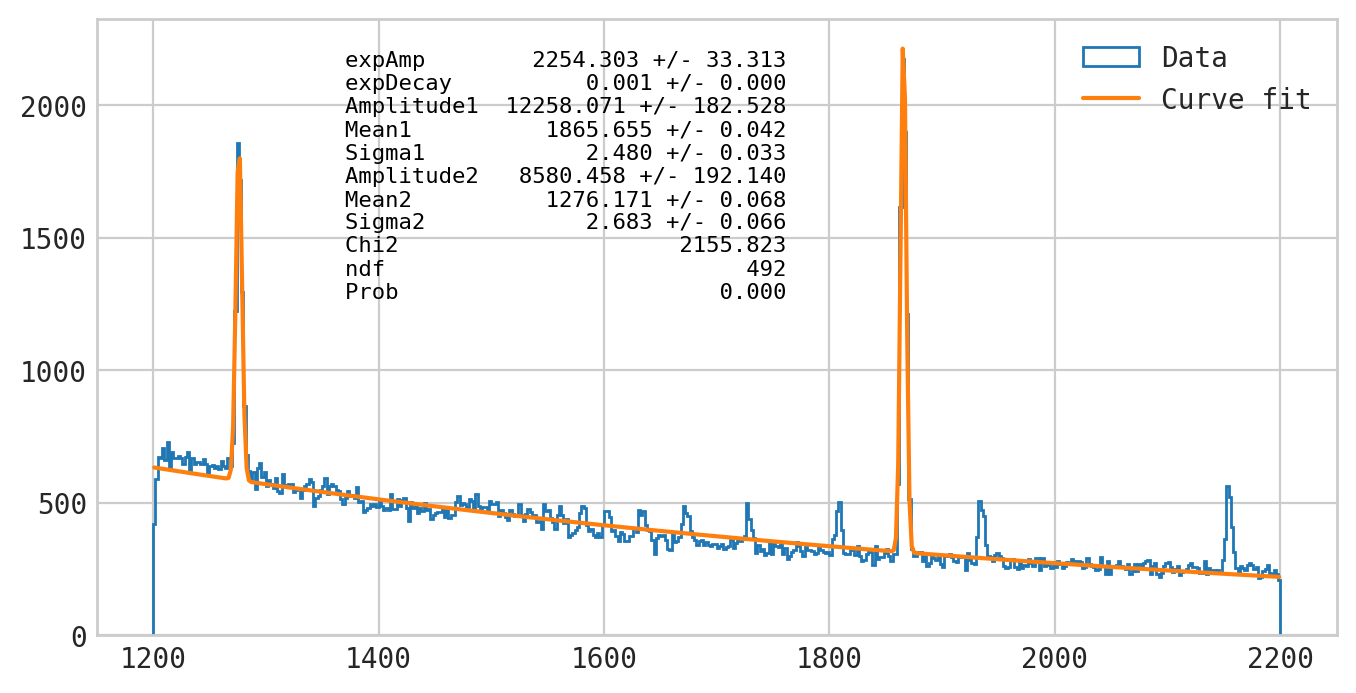

In [227]:
filtered_data = dataframe[(1200 < dataframe['Wavelength']) & (dataframe['Wavelength'] < 2200)]['Wavelength']

Nbins = 500

y, x_edges = np.histogram(filtered_data, bins=Nbins)

x = (x_edges[1:] + x_edges[:-1])/2

chi2_object = Chi2Regression(fit_2_peaks, x[y>0], y[y>0], np.sqrt(y)[y>0])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

minuit = Minuit(chi2_object, expAmp=3000, expDecay=0.001, amp1=10000, mu1=1865, sigma1=10, amp2=10000, mu2=1282, sigma2=10)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 8                   # Number of variables (expAmp, expDecay, amp1, mu1, sigma1, amp2, mu2, sigma2)
Ndof_fit = Nbins - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
plt.hist(filtered_data, bins=Nbins, histtype='step', label='Data')
plt.plot(x, fit_2_peaks(x, minuit.values['expAmp'], minuit.values['expDecay'], minuit.values['amp1'], minuit.values['mu1'],
         minuit.values['sigma1'], minuit.values['amp2'], minuit.values['mu2'], minuit.values['sigma2']), label=f'Curve fit')
plt.legend()

d = {'expAmp': [minuit.values['expAmp'], minuit.errors['expAmp']],
     'expDecay': [minuit.values['expDecay'], minuit.errors['expDecay']],
     'Amplitude1': [minuit.values['amp1'], minuit.errors['amp1']],
     'Mean1': [minuit.values['mu1'], minuit.errors['mu1']],
     'Sigma1': [minuit.values['sigma1'], minuit.errors['sigma1']],
     'Amplitude2': [minuit.values['amp2'], minuit.errors['amp2']],
     'Mean2': [minuit.values['mu2'], minuit.errors['mu2']],
     'Sigma2': [minuit.values['sigma2'], minuit.errors['sigma2']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.2, 0.95, text, ax, fontsize=8)


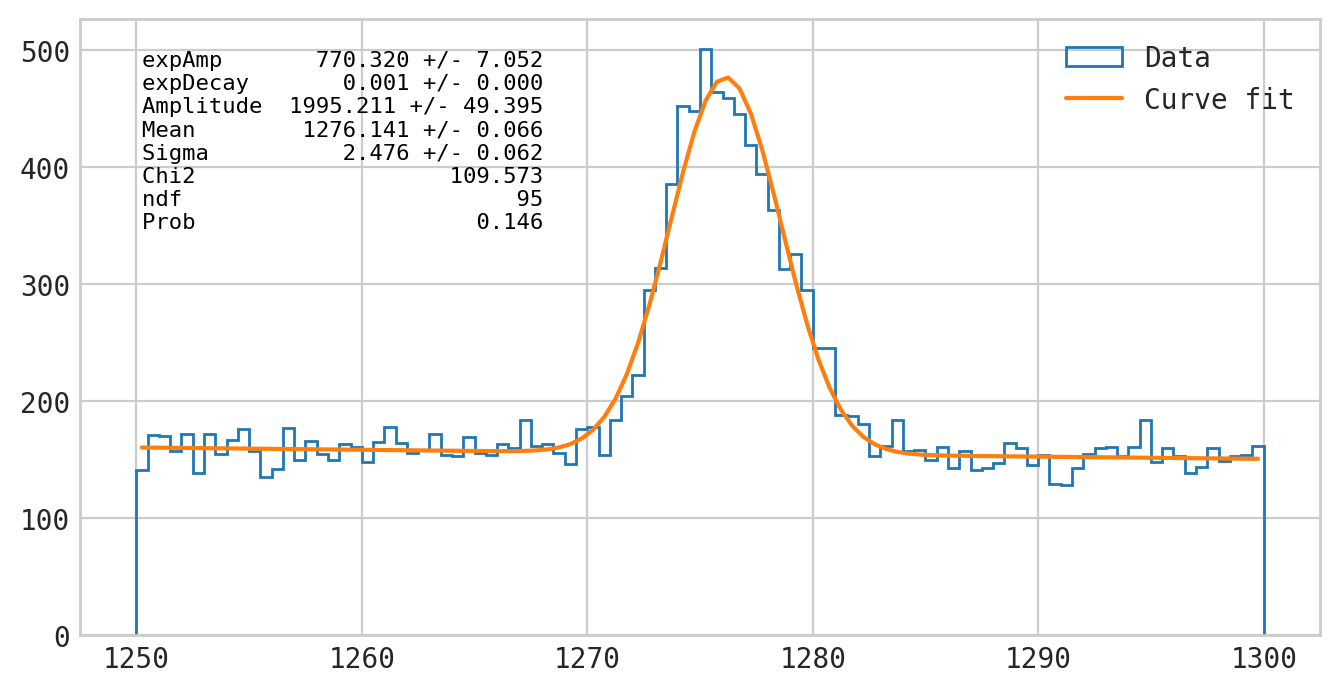

In [236]:
filtered_data = dataframe[(1250 < dataframe['Wavelength']) & (dataframe['Wavelength'] < 1300)]['Wavelength']

Nbins = 100

y, x_edges = np.histogram(filtered_data, bins=Nbins)

x = (x_edges[1:] + x_edges[:-1])/2

chi2_object = Chi2Regression(fit_1_peak, x[y>0], y[y>0], np.sqrt(y)[y>0])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

minuit = Minuit(chi2_object, expAmp=2254, expDecay=0.001, amp=8580, mu=1276, sigma=2)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 5                   # Number of variables (expAmp, expDecay, amp, mu, sigma)
Ndof_fit = Nbins - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
plt.hist(filtered_data, bins=Nbins, histtype='step', label='Data')
plt.plot(x, fit_1_peak(x, minuit.values['expAmp'], minuit.values['expDecay'], minuit.values['amp'], 
         minuit.values['mu'], minuit.values['sigma']), label=f'Curve fit')
plt.legend()

d = {'expAmp': [minuit.values['expAmp'], minuit.errors['expAmp']],
     'expDecay': [minuit.values['expDecay'], minuit.errors['expDecay']],
     'Amplitude': [minuit.values['amp'], minuit.errors['amp']],
     'Mean': [minuit.values['mu'], minuit.errors['mu']],
     'Sigma': [minuit.values['sigma'], minuit.errors['sigma']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.05, 0.95, text, ax, fontsize=8)


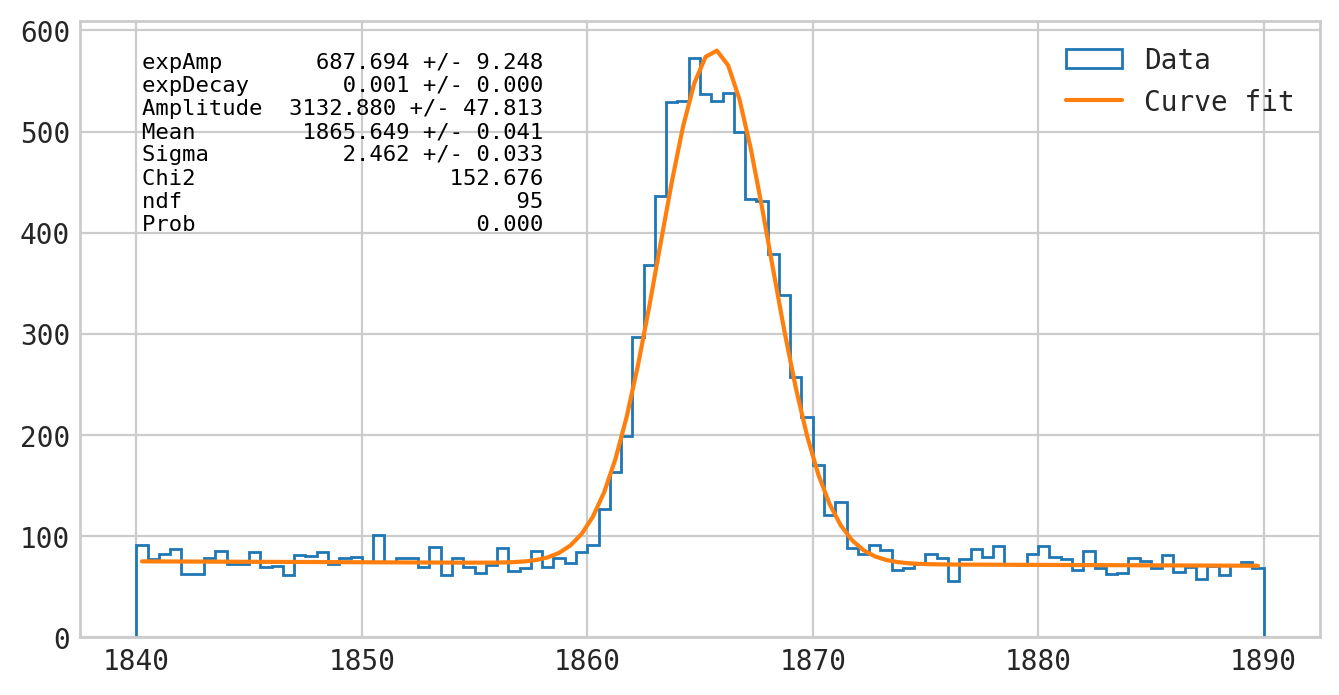

In [243]:
filtered_data = dataframe[(1840 < dataframe['Wavelength']) & (dataframe['Wavelength'] < 1890)]['Wavelength']

Nbins = 100

y, x_edges = np.histogram(filtered_data, bins=Nbins)

x = (x_edges[1:] + x_edges[:-1])/2

chi2_object = Chi2Regression(fit_1_peak, x[y>0], y[y>0], np.sqrt(y)[y>0])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

minuit = Minuit(chi2_object, expAmp=2254, expDecay=0.001, amp=12258, mu=1865, sigma=2)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 5                   # Number of variables (expAmp, expDecay, amp, mu, sigma)
Ndof_fit = Nbins - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
plt.hist(filtered_data, bins=Nbins, histtype='step', label='Data')
plt.plot(x, fit_1_peak(x, minuit.values['expAmp'], minuit.values['expDecay'], minuit.values['amp'], 
         minuit.values['mu'], minuit.values['sigma']), label=f'Curve fit')
plt.legend()

d = {'expAmp': [minuit.values['expAmp'], minuit.errors['expAmp']],
     'expDecay': [minuit.values['expDecay'], minuit.errors['expDecay']],
     'Amplitude': [minuit.values['amp'], minuit.errors['amp']],
     'Mean': [minuit.values['mu'], minuit.errors['mu']],
     'Sigma': [minuit.values['sigma'], minuit.errors['sigma']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.05, 0.95, text, ax, fontsize=8)


In [248]:
known_pos = np.array([1875.637, 1282.174])
observed_pos = np.array([1865.649, 1276.141])
M = np.vstack((observed_pos, np.ones_like(observed_pos))).T
a, b = np.linalg.solve(M, known_pos)
a, b

(1.0067089844412633, -2.5286101138582953)

In [250]:
def calibrate_positions_linear(position, a=1.0067089844412633, b=-2.5286101138582953):
    return position * a + b

calibrate_positions_linear(observed_pos)

array([1875.637, 1282.174])

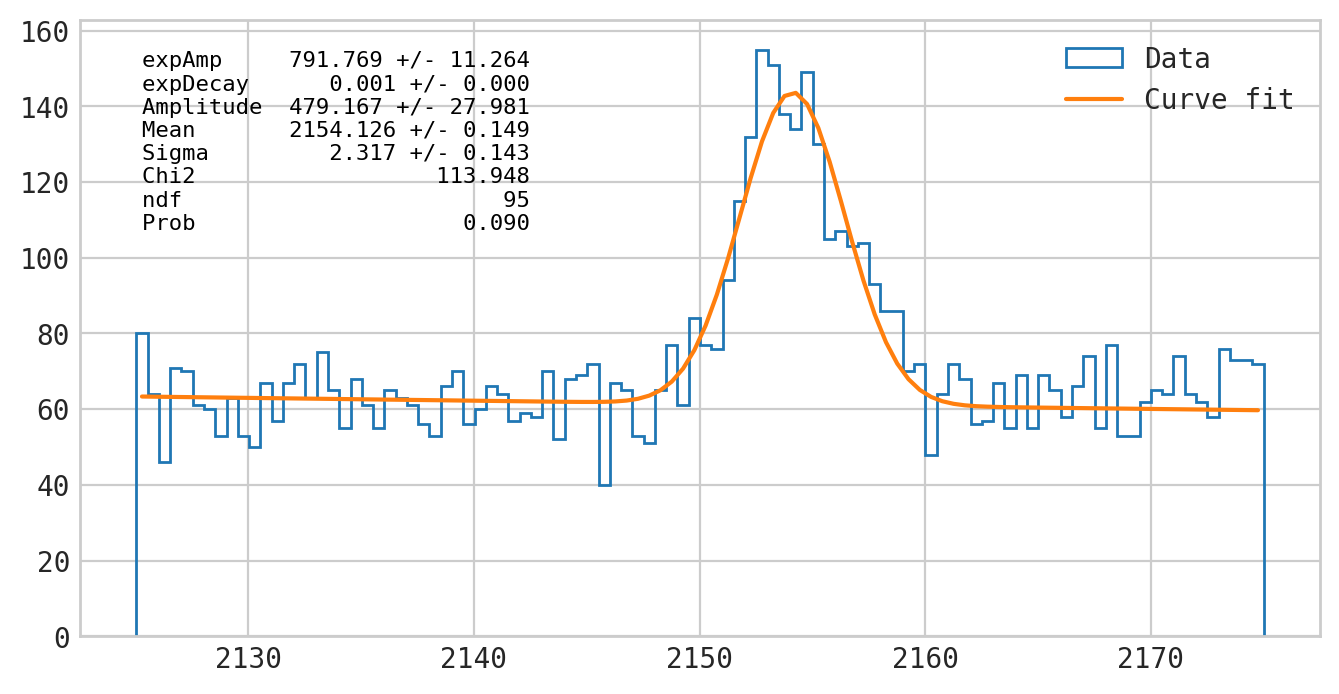

In [251]:
filtered_data = dataframe[(2125 < dataframe['Wavelength']) & (dataframe['Wavelength'] < 2175)]['Wavelength']

Nbins = 100

y, x_edges = np.histogram(filtered_data, bins=Nbins)

x = (x_edges[1:] + x_edges[:-1])/2

chi2_object = Chi2Regression(fit_1_peak, x[y>0], y[y>0], np.sqrt(y)[y>0])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

minuit = Minuit(chi2_object, expAmp=2254, expDecay=0.001, amp=8580, mu=2150, sigma=2)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 5                   # Number of variables (expAmp, expDecay, amp, mu, sigma)
Ndof_fit = Nbins - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
plt.hist(filtered_data, bins=Nbins, histtype='step', label='Data')
plt.plot(x, fit_1_peak(x, minuit.values['expAmp'], minuit.values['expDecay'], minuit.values['amp'], 
         minuit.values['mu'], minuit.values['sigma']), label=f'Curve fit')
plt.legend()

d = {'expAmp': [minuit.values['expAmp'], minuit.errors['expAmp']],
     'expDecay': [minuit.values['expDecay'], minuit.errors['expDecay']],
     'Amplitude': [minuit.values['amp'], minuit.errors['amp']],
     'Mean': [minuit.values['mu'], minuit.errors['mu']],
     'Sigma': [minuit.values['sigma'], minuit.errors['sigma']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.05, 0.95, text, ax, fontsize=8)


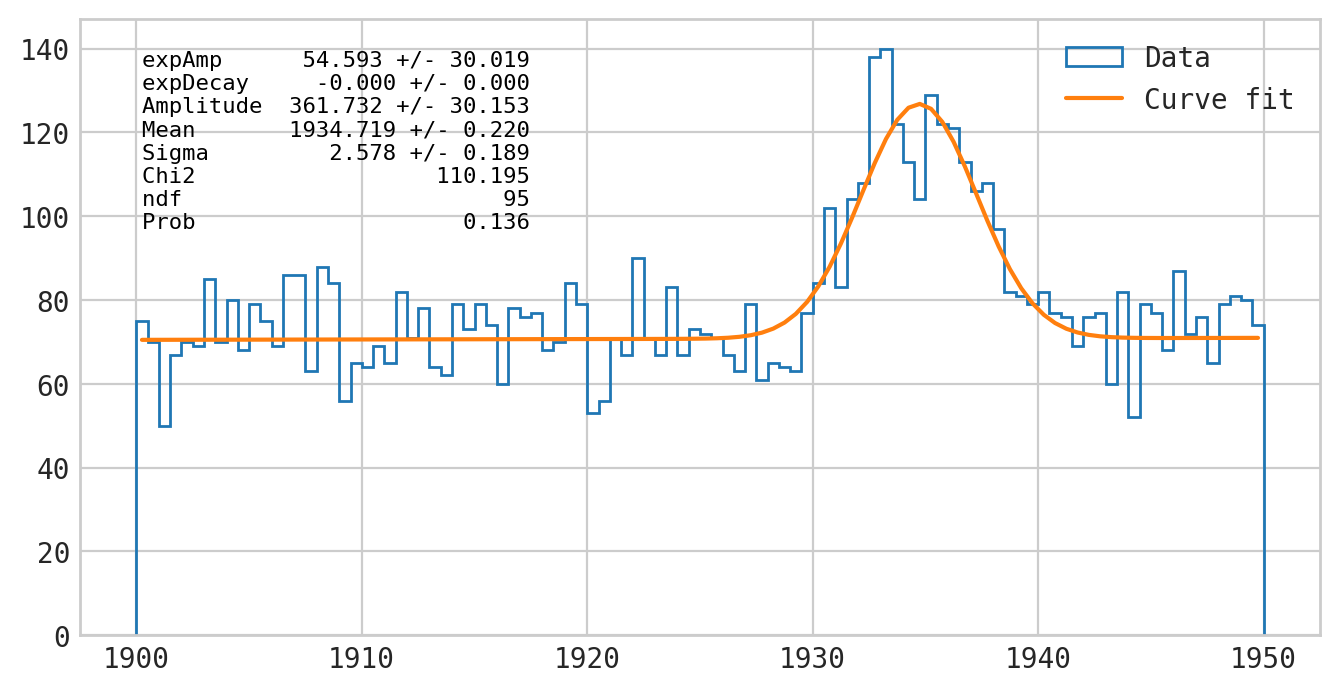

In [254]:
filtered_data = dataframe[(1900 < dataframe['Wavelength']) & (dataframe['Wavelength'] < 1950)]['Wavelength']

Nbins = 100

y, x_edges = np.histogram(filtered_data, bins=Nbins)

x = (x_edges[1:] + x_edges[:-1])/2

chi2_object = Chi2Regression(fit_1_peak, x[y>0], y[y>0], np.sqrt(y)[y>0])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

minuit = Minuit(chi2_object, expAmp=2254, expDecay=0.001, amp=8580, mu=1935, sigma=2)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 5                   # Number of variables (expAmp, expDecay, amp, mu, sigma)
Ndof_fit = Nbins - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
plt.hist(filtered_data, bins=Nbins, histtype='step', label='Data')
plt.plot(x, fit_1_peak(x, minuit.values['expAmp'], minuit.values['expDecay'], minuit.values['amp'], 
         minuit.values['mu'], minuit.values['sigma']), label=f'Curve fit')
plt.legend()

d = {'expAmp': [minuit.values['expAmp'], minuit.errors['expAmp']],
     'expDecay': [minuit.values['expDecay'], minuit.errors['expDecay']],
     'Amplitude': [minuit.values['amp'], minuit.errors['amp']],
     'Mean': [minuit.values['mu'], minuit.errors['mu']],
     'Sigma': [minuit.values['sigma'], minuit.errors['sigma']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.05, 0.95, text, ax, fontsize=8)


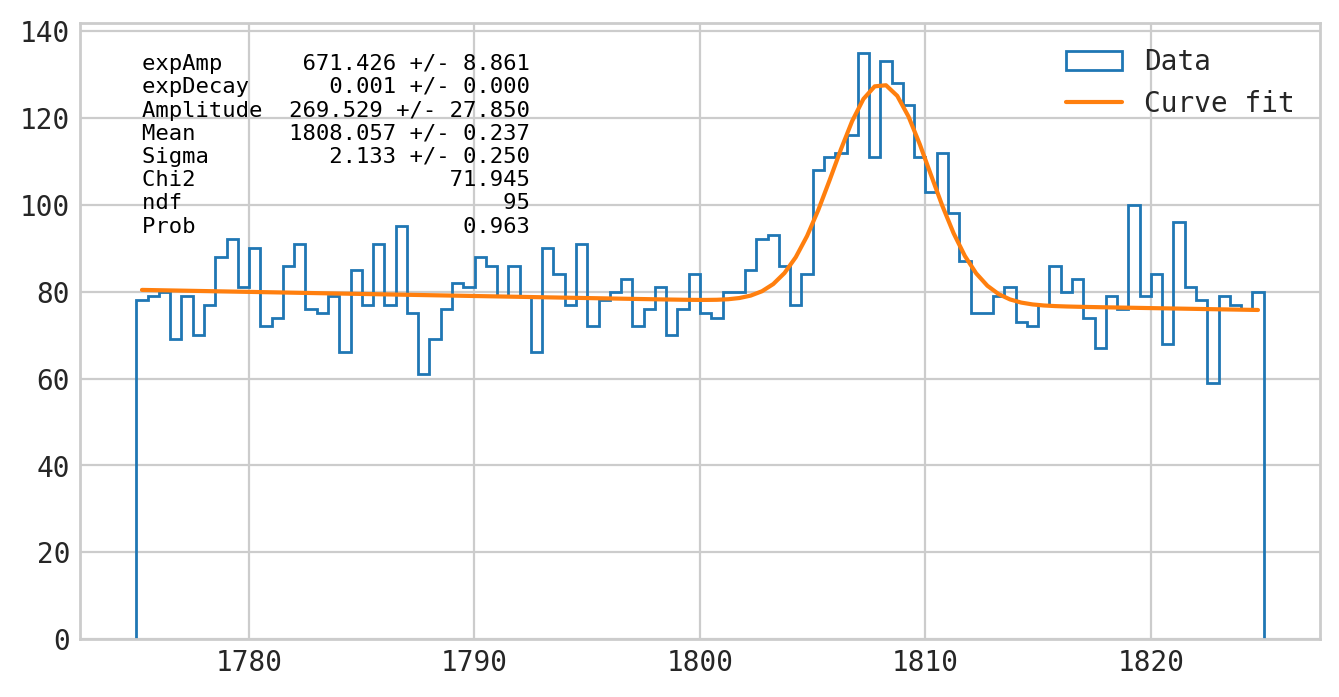

In [257]:
filtered_data = dataframe[(1775 < dataframe['Wavelength']) & (dataframe['Wavelength'] < 1825)]['Wavelength']

Nbins = 100

y, x_edges = np.histogram(filtered_data, bins=Nbins)

x = (x_edges[1:] + x_edges[:-1])/2

chi2_object = Chi2Regression(fit_1_peak, x[y>0], y[y>0], np.sqrt(y)[y>0])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

minuit = Minuit(chi2_object, expAmp=2254, expDecay=0.001, amp=8580, mu=1809, sigma=2)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 5                   # Number of variables (expAmp, expDecay, amp, mu, sigma)
Ndof_fit = Nbins - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
plt.hist(filtered_data, bins=Nbins, histtype='step', label='Data')
plt.plot(x, fit_1_peak(x, minuit.values['expAmp'], minuit.values['expDecay'], minuit.values['amp'], 
         minuit.values['mu'], minuit.values['sigma']), label=f'Curve fit')
plt.legend()

d = {'expAmp': [minuit.values['expAmp'], minuit.errors['expAmp']],
     'expDecay': [minuit.values['expDecay'], minuit.errors['expDecay']],
     'Amplitude': [minuit.values['amp'], minuit.errors['amp']],
     'Mean': [minuit.values['mu'], minuit.errors['mu']],
     'Sigma': [minuit.values['sigma'], minuit.errors['sigma']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.05, 0.95, text, ax, fontsize=8)


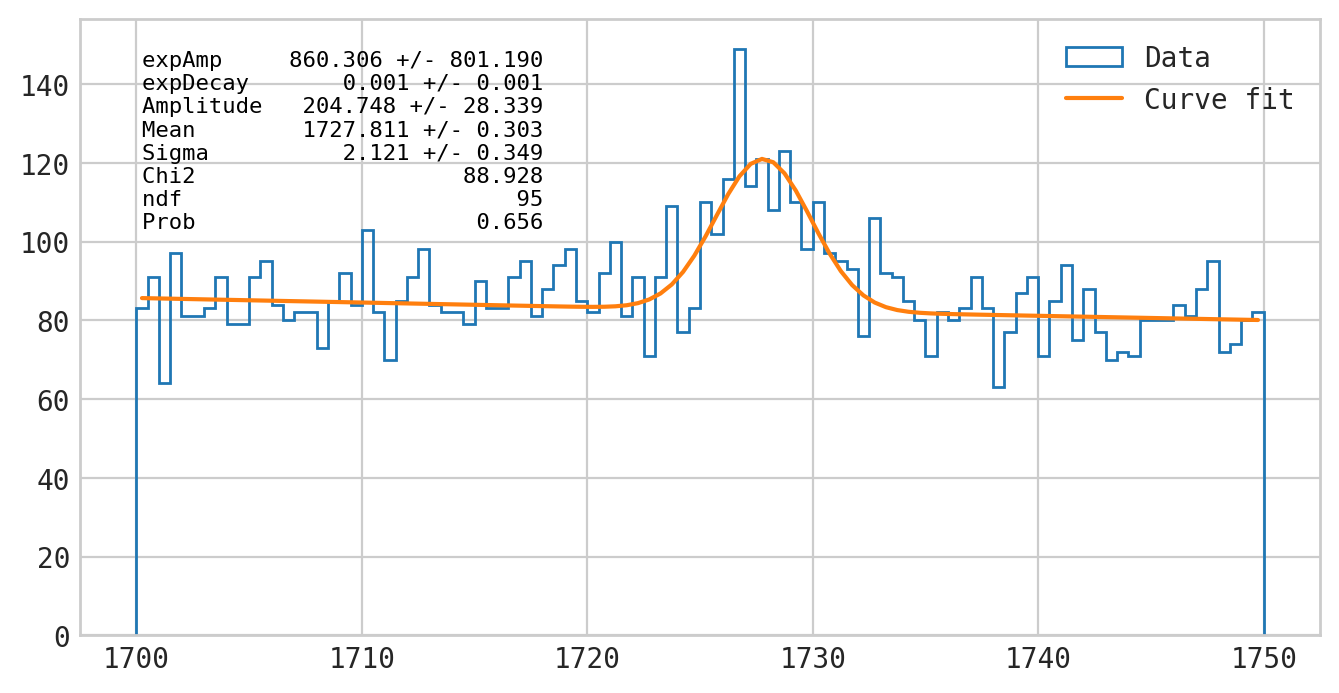

In [258]:
filtered_data = dataframe[(1700 < dataframe['Wavelength']) & (dataframe['Wavelength'] < 1750)]['Wavelength']

Nbins = 100

y, x_edges = np.histogram(filtered_data, bins=Nbins)

x = (x_edges[1:] + x_edges[:-1])/2

chi2_object = Chi2Regression(fit_1_peak, x[y>0], y[y>0], np.sqrt(y)[y>0])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

minuit = Minuit(chi2_object, expAmp=2254, expDecay=0.001, amp=8580, mu=1725, sigma=2)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 5                   # Number of variables (expAmp, expDecay, amp, mu, sigma)
Ndof_fit = Nbins - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
plt.hist(filtered_data, bins=Nbins, histtype='step', label='Data')
plt.plot(x, fit_1_peak(x, minuit.values['expAmp'], minuit.values['expDecay'], minuit.values['amp'], 
         minuit.values['mu'], minuit.values['sigma']), label=f'Curve fit')
plt.legend()

d = {'expAmp': [minuit.values['expAmp'], minuit.errors['expAmp']],
     'expDecay': [minuit.values['expDecay'], minuit.errors['expDecay']],
     'Amplitude': [minuit.values['amp'], minuit.errors['amp']],
     'Mean': [minuit.values['mu'], minuit.errors['mu']],
     'Sigma': [minuit.values['sigma'], minuit.errors['sigma']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.05, 0.95, text, ax, fontsize=8)


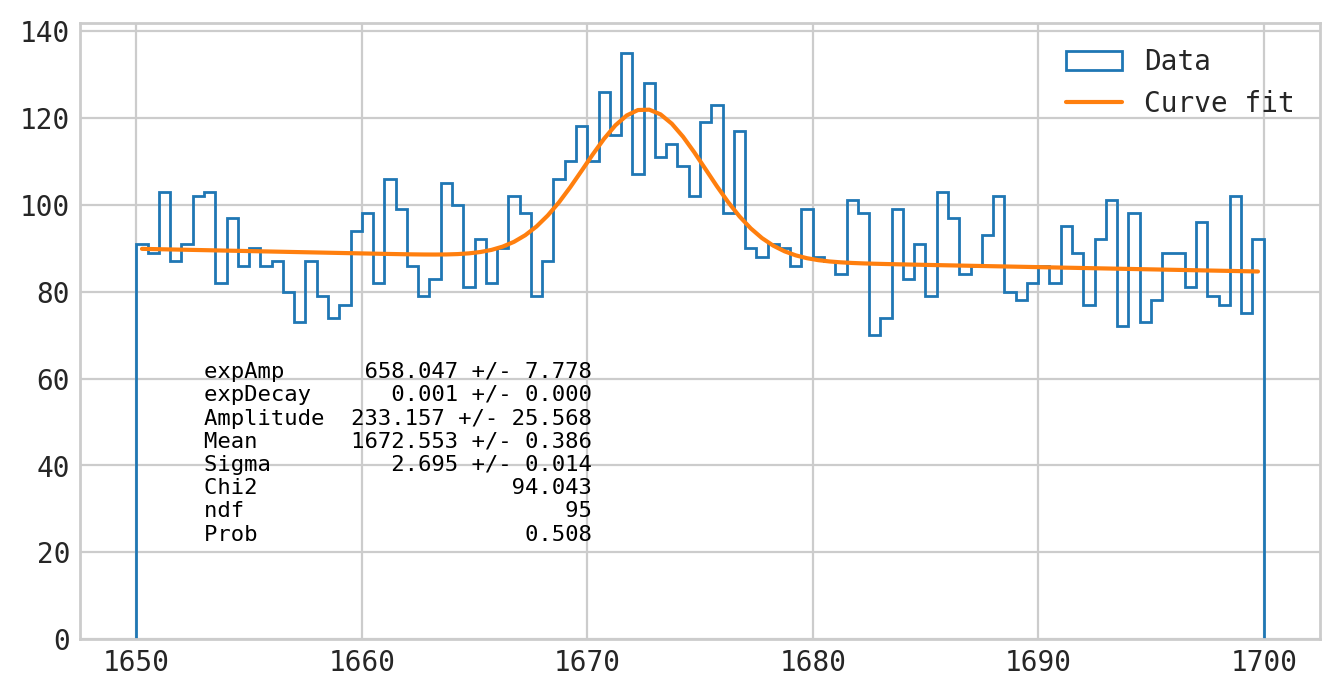

In [263]:
filtered_data = dataframe[(1650 < dataframe['Wavelength']) & (dataframe['Wavelength'] < 1700)]['Wavelength']

Nbins = 100

y, x_edges = np.histogram(filtered_data, bins=Nbins)

x = (x_edges[1:] + x_edges[:-1])/2

chi2_object = Chi2Regression(fit_1_peak, x[y>0], y[y>0], np.sqrt(y)[y>0])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

minuit = Minuit(chi2_object, expAmp=2254, expDecay=0.001, amp=8580, mu=1675, sigma=2)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 5                   # Number of variables (expAmp, expDecay, amp, mu, sigma)
Ndof_fit = Nbins - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
plt.hist(filtered_data, bins=Nbins, histtype='step', label='Data')
plt.plot(x, fit_1_peak(x, minuit.values['expAmp'], minuit.values['expDecay'], minuit.values['amp'], 
         minuit.values['mu'], minuit.values['sigma']), label=f'Curve fit')
plt.legend()

d = {'expAmp': [minuit.values['expAmp'], minuit.errors['expAmp']],
     'expDecay': [minuit.values['expDecay'], minuit.errors['expDecay']],
     'Amplitude': [minuit.values['amp'], minuit.errors['amp']],
     'Mean': [minuit.values['mu'], minuit.errors['mu']],
     'Sigma': [minuit.values['sigma'], minuit.errors['sigma']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.1, 0.45, text, ax, fontsize=8)


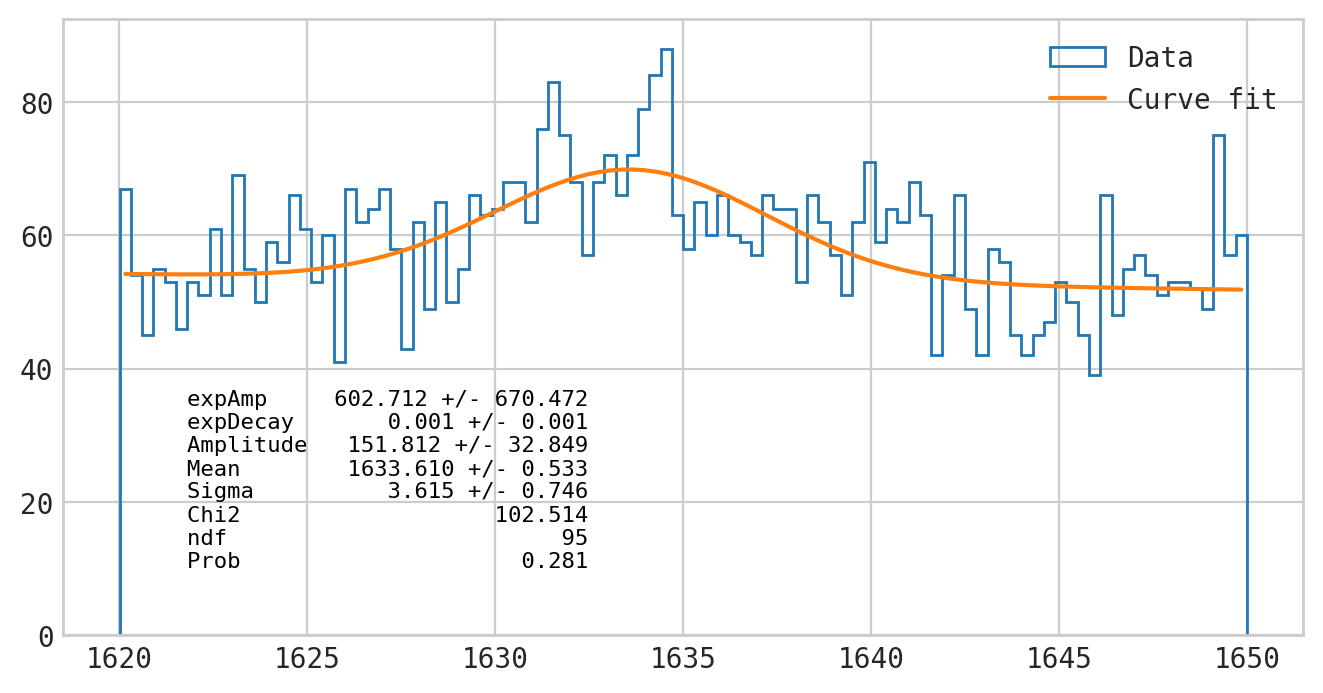

In [274]:
filtered_data = dataframe[(1620 < dataframe['Wavelength']) & (dataframe['Wavelength'] < 1650)]['Wavelength']

Nbins = 100

y, x_edges = np.histogram(filtered_data, bins=Nbins)

x = (x_edges[1:] + x_edges[:-1])/2

chi2_object = Chi2Regression(fit_1_peak, x[y>0], y[y>0], np.sqrt(y)[y>0])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

minuit = Minuit(chi2_object, expAmp=2254, expDecay=0.001, amp=8580, mu=1625, sigma=2)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 5                   # Number of variables (expAmp, expDecay, amp, mu, sigma)
Ndof_fit = Nbins - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
plt.hist(filtered_data, bins=Nbins, histtype='step', label='Data')
plt.plot(x, fit_1_peak(x, minuit.values['expAmp'], minuit.values['expDecay'], minuit.values['amp'], 
         minuit.values['mu'], minuit.values['sigma']), label=f'Curve fit')
plt.legend()

d = {'expAmp': [minuit.values['expAmp'], minuit.errors['expAmp']],
     'expDecay': [minuit.values['expDecay'], minuit.errors['expDecay']],
     'Amplitude': [minuit.values['amp'], minuit.errors['amp']],
     'Mean': [minuit.values['mu'], minuit.errors['mu']],
     'Sigma': [minuit.values['sigma'], minuit.errors['sigma']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.1, 0.4, text, ax, fontsize=8)


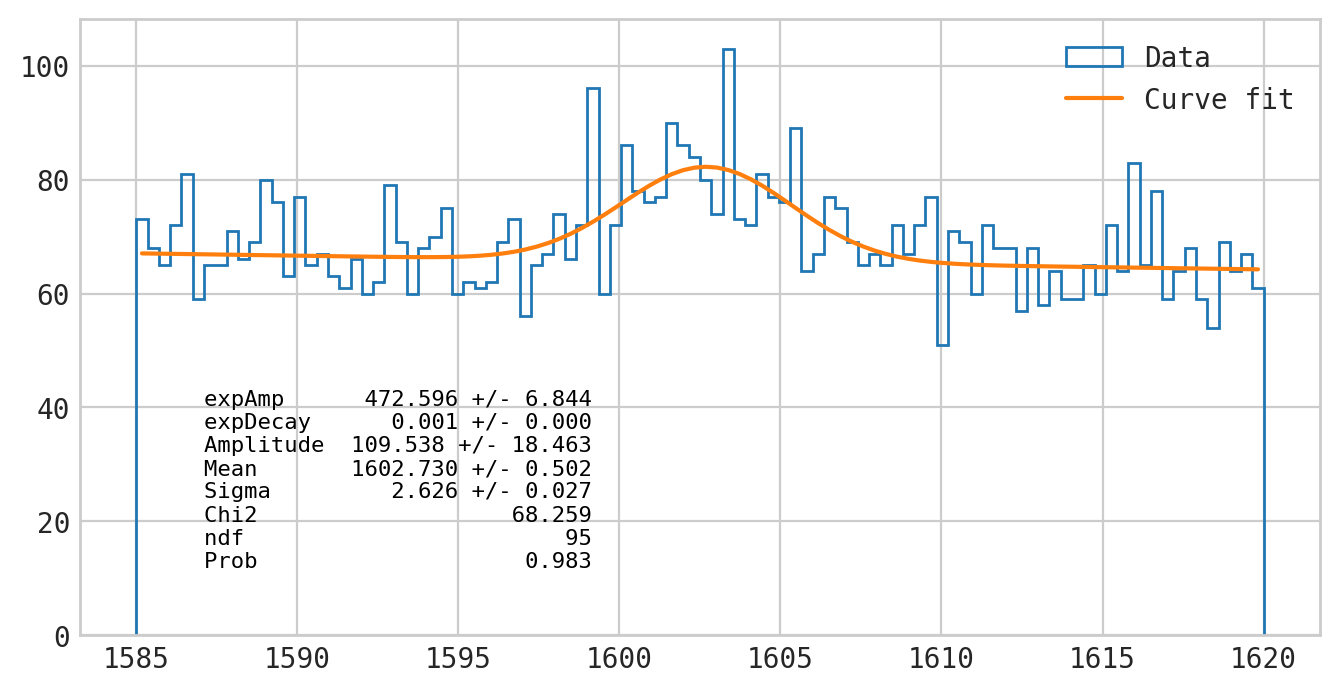

In [291]:
filtered_data = dataframe[(1585 < dataframe['Wavelength']) & (dataframe['Wavelength'] < 1620)]['Wavelength']

Nbins = 100

y, x_edges = np.histogram(filtered_data, bins=Nbins)

x = (x_edges[1:] + x_edges[:-1])/2

chi2_object = Chi2Regression(fit_1_peak, x[y>0], y[y>0], np.sqrt(y)[y>0])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

minuit = Minuit(chi2_object, expAmp=2254, expDecay=0.001, amp=8580, mu=1610, sigma=2)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 5                   # Number of variables (expAmp, expDecay, amp, mu, sigma)
Ndof_fit = Nbins - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
plt.hist(filtered_data, bins=Nbins, histtype='step', label='Data')
plt.plot(x, fit_1_peak(x, minuit.values['expAmp'], minuit.values['expDecay'], minuit.values['amp'], 
         minuit.values['mu'], minuit.values['sigma']), label=f'Curve fit')
plt.legend()

d = {'expAmp': [minuit.values['expAmp'], minuit.errors['expAmp']],
     'expDecay': [minuit.values['expDecay'], minuit.errors['expDecay']],
     'Amplitude': [minuit.values['amp'], minuit.errors['amp']],
     'Mean': [minuit.values['mu'], minuit.errors['mu']],
     'Sigma': [minuit.values['sigma'], minuit.errors['sigma']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.1, 0.4, text, ax, fontsize=8)


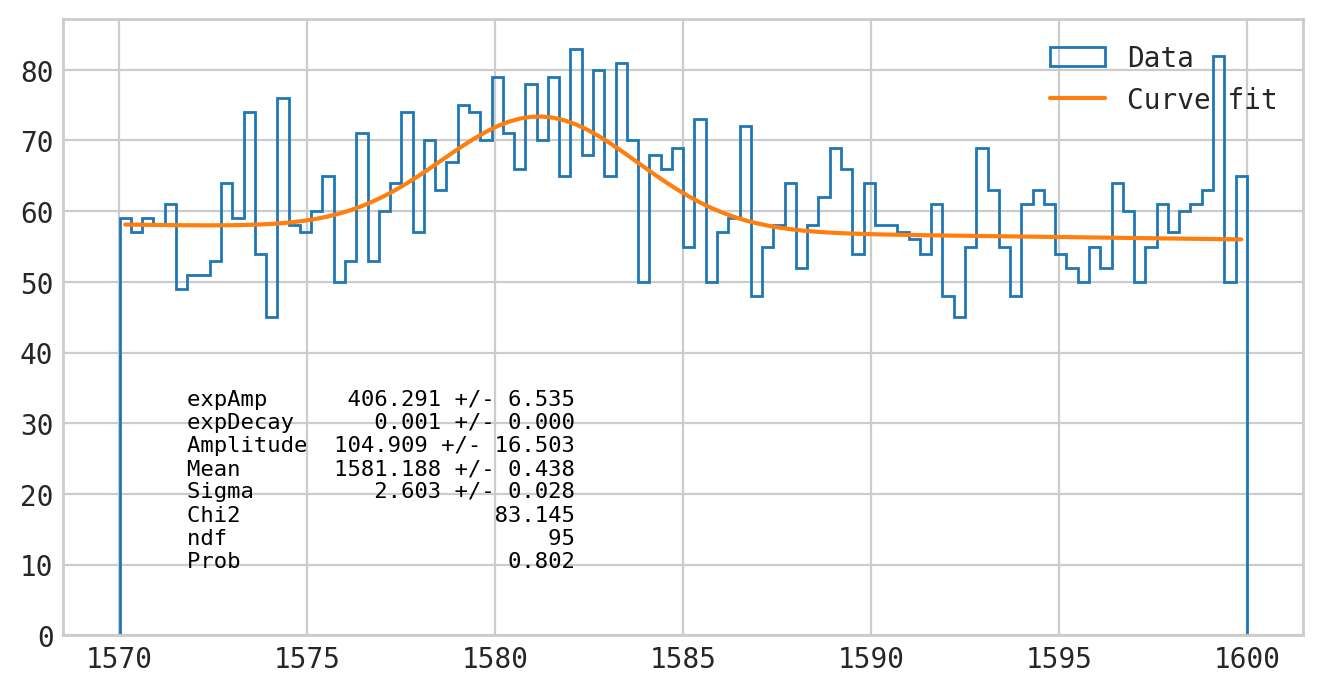

In [277]:
filtered_data = dataframe[(1570 < dataframe['Wavelength']) & (dataframe['Wavelength'] < 1600)]['Wavelength']

Nbins = 100

y, x_edges = np.histogram(filtered_data, bins=Nbins)

x = (x_edges[1:] + x_edges[:-1])/2

chi2_object = Chi2Regression(fit_1_peak, x[y>0], y[y>0], np.sqrt(y)[y>0])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

minuit = Minuit(chi2_object, expAmp=2254, expDecay=0.001, amp=8580, mu=1580, sigma=2)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 5                   # Number of variables (expAmp, expDecay, amp, mu, sigma)
Ndof_fit = Nbins - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
plt.hist(filtered_data, bins=Nbins, histtype='step', label='Data')
plt.plot(x, fit_1_peak(x, minuit.values['expAmp'], minuit.values['expDecay'], minuit.values['amp'], 
         minuit.values['mu'], minuit.values['sigma']), label=f'Curve fit')
plt.legend()

d = {'expAmp': [minuit.values['expAmp'], minuit.errors['expAmp']],
     'expDecay': [minuit.values['expDecay'], minuit.errors['expDecay']],
     'Amplitude': [minuit.values['amp'], minuit.errors['amp']],
     'Mean': [minuit.values['mu'], minuit.errors['mu']],
     'Sigma': [minuit.values['sigma'], minuit.errors['sigma']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.1, 0.4, text, ax, fontsize=8)


In [292]:
observed_others = np.array([2154.126,
                            1924.719,
                            1808.057,
                            1727.811,
                            1672.553,
                            1633.610,
                            1602.730,
                            1581.188])

calibrate_positions_linear(observed_others)

array([2166.0493877 , 1935.10329971, 1817.65861617, 1736.874247  ,
       1681.24552194, 1642.04125396, 1610.95408052, 1589.26755558])

In [285]:
def rydberg_wavelength(n1, n2):
    R_inf =  1.09677e7
    one_by_lambda = R_inf*(1/n1**2 - 1/n2**2)
    return (1/one_by_lambda) * 1e9

n1s = [3, 4]
for n1 in n1s:
    for n2 in np.arange(n1+1, n1+11):
        print(f"{n1=}, {n2=}, {rydberg_wavelength(n1, n2):.2f}")


n1=3, n2=4, 1875.64
n1=3, n2=5, 1282.17
n1=3, n2=6, 1094.12
n1=3, n2=7, 1005.22
n1=3, n2=8, 954.87
n1=3, n2=9, 923.17
n1=3, n2=10, 901.75
n1=3, n2=11, 886.53
n1=3, n2=12, 875.30
n1=3, n2=13, 866.75
n1=4, n2=5, 4052.30
n1=4, n2=6, 2625.89
n1=4, n2=7, 2166.14
n1=4, n2=8, 1945.11
n1=4, n2=9, 1817.93
n1=4, n2=10, 1736.70
n1=4, n2=11, 1681.13
n1=4, n2=12, 1641.18
n1=4, n2=13, 1611.39
n1=4, n2=14, 1588.50


In [294]:
observed_errors = np.array([0.149,
                            0.22,
                            0.237,
                            0.303,
                            0.386,
                            0.533,
                            0.502,
                            0.438])

calibrate_positions_linear(observed_errors, a=1.0067089844412633, b=0)

array([0.14999964, 0.22147598, 0.23859003, 0.30503282, 0.38858967,
       0.53657589, 0.50536791, 0.44093854])

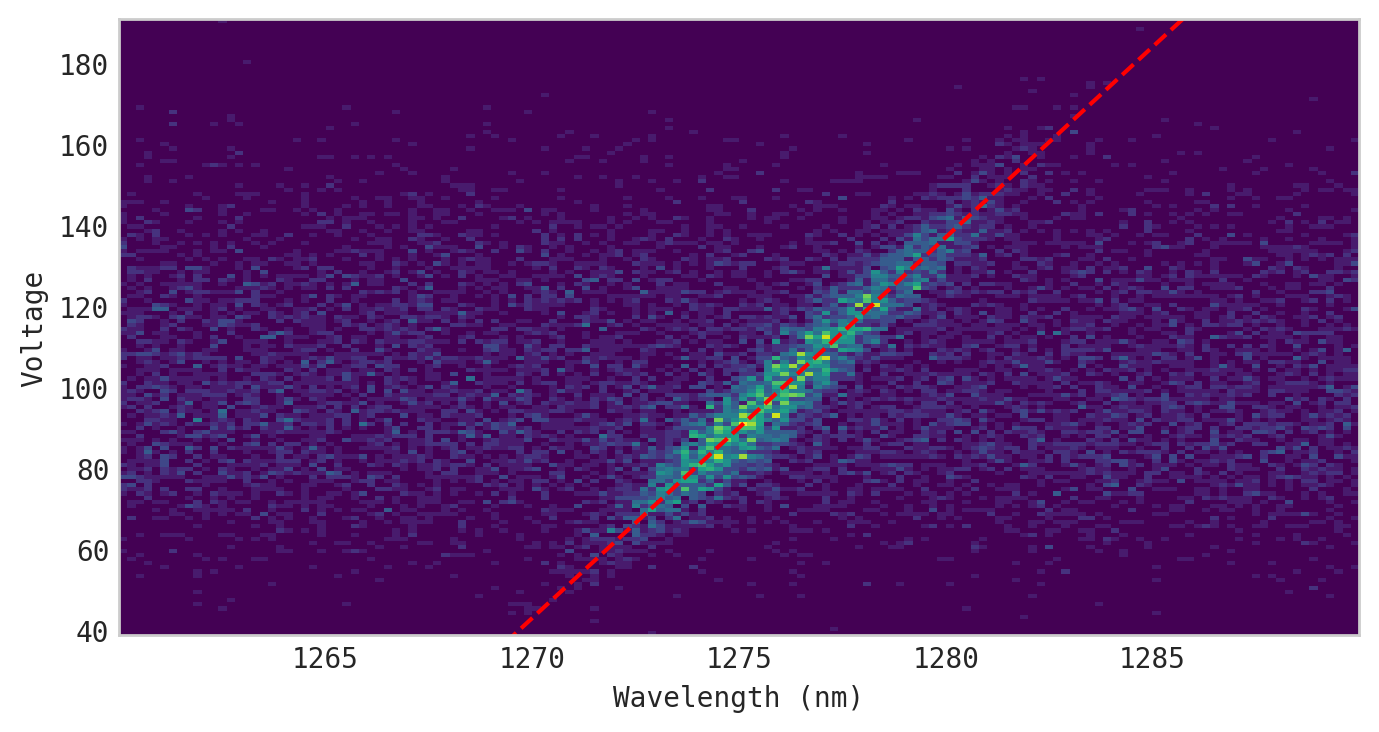

In [360]:
filtered_data = dataframe[(1260 < dataframe['Wavelength']) & (dataframe['Wavelength'] < 1290)]

def calibrate_voltage(wavelength, a=9.4):
    b = 90 - a*(1275)
    return a*wavelength + b

plt.hist2d(filtered_data['Wavelength'], filtered_data['Voltage'], [150,150], cmap='viridis')
x = np.linspace(1260, 1290, 5)
plt.plot(x, calibrate_voltage(x), c='r', linestyle='--')
plt.ylabel('Voltage')
plt.xlabel('Wavelength (nm)');

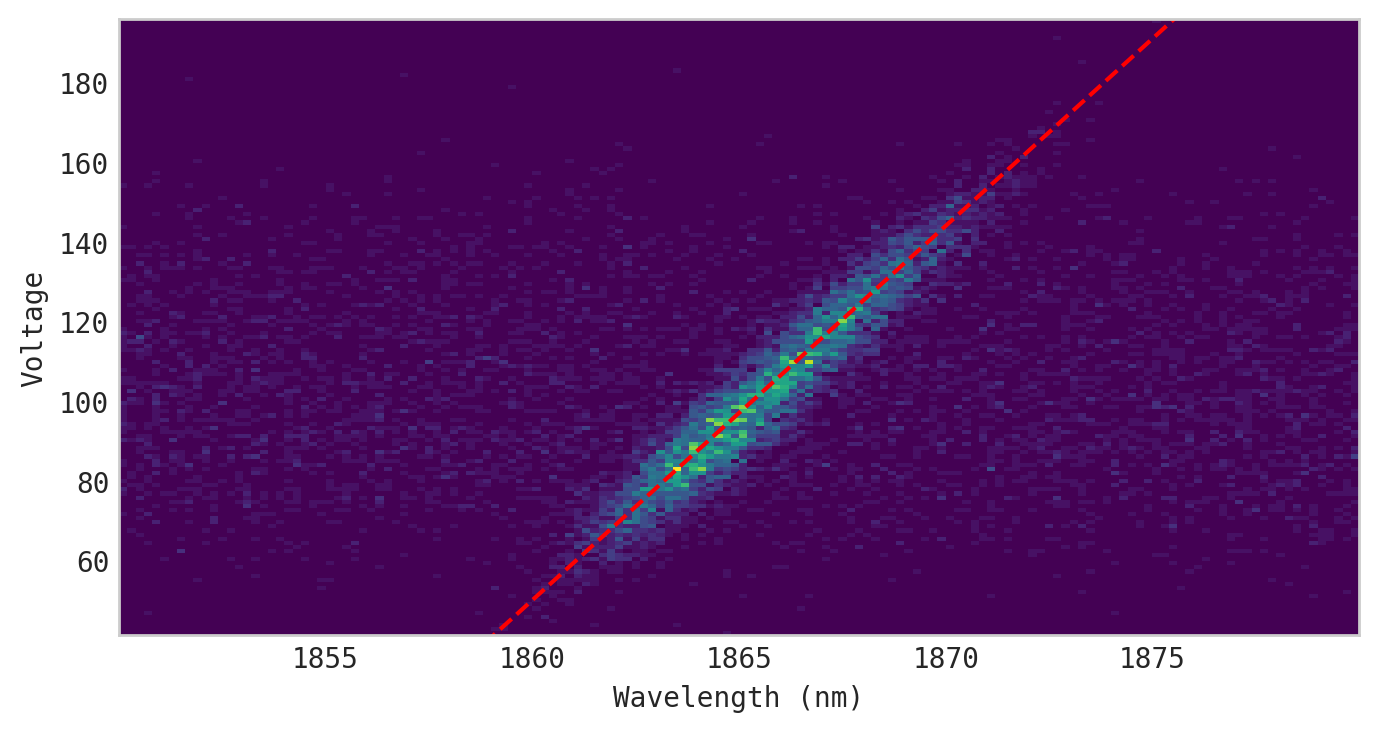

In [362]:
filtered_data = dataframe[(1850 < dataframe['Wavelength']) & (dataframe['Wavelength'] < 1880)]

def calibrate_voltage(wavelength, a=9.4):
    b = 97 - a*(1865)
    return a*wavelength + b

plt.hist2d(filtered_data['Wavelength'], filtered_data['Voltage'], [150,150], cmap='viridis')
x = np.linspace(1850, 1880, 5)
plt.plot(x, calibrate_voltage(x), c='r', linestyle='--')
plt.ylabel('Voltage')
plt.xlabel('Wavelength (nm)');

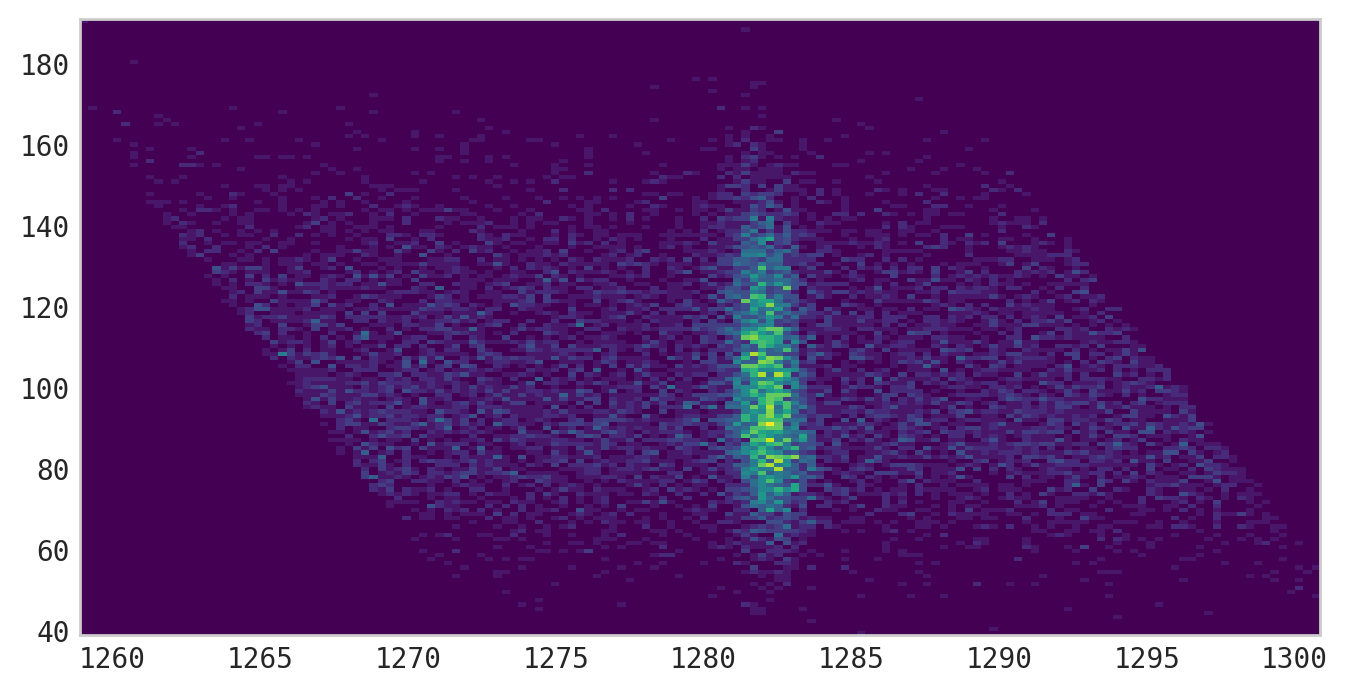

In [397]:
df2 = dataframe
df2['Calibrated Wavelength'] = 1282.174 + df2['Wavelength'] - (df2['Voltage']- (90 - 9.4*(1275)))/9.4

filtered_data = df2[(1260 < df2['Wavelength']) & (df2['Wavelength'] < 1290)]

plt.hist2d(filtered_data['Calibrated Wavelength'], filtered_data['Voltage'], [150,150], cmap='viridis');


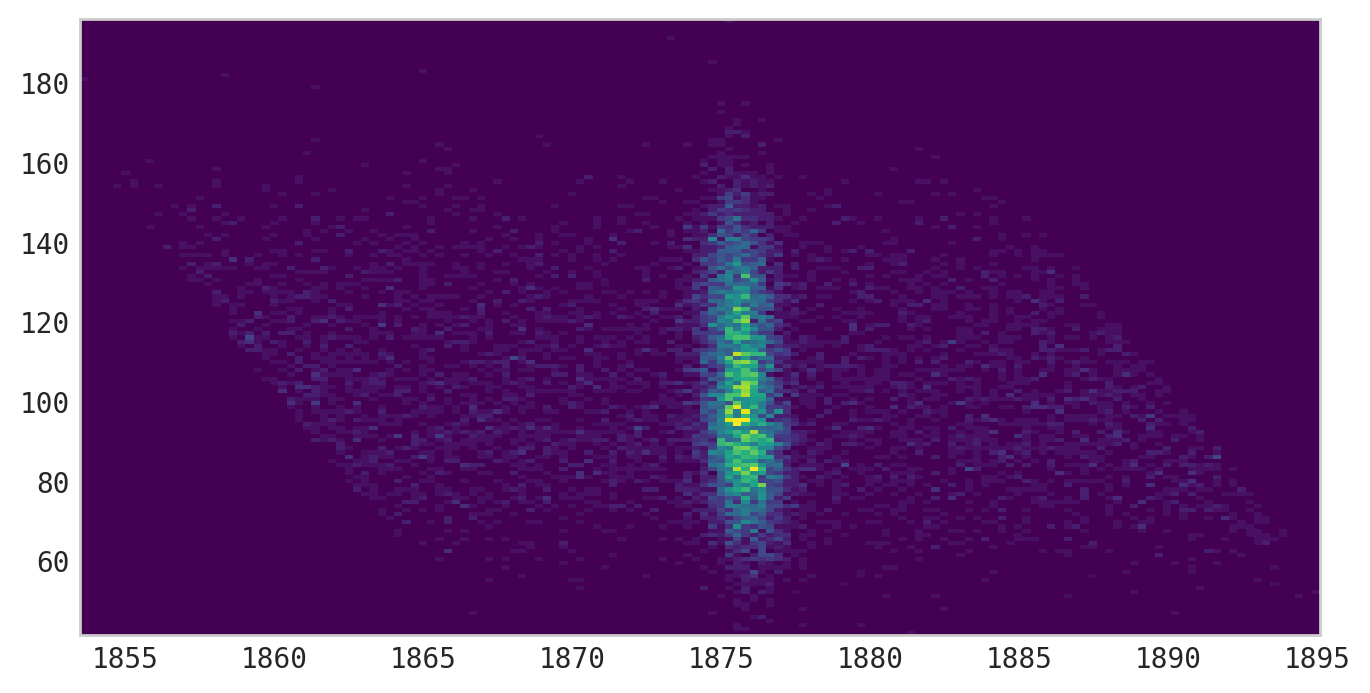

In [399]:
df2 = dataframe
df2['Calibrated Wavelength'] = 1875.637 + df2['Wavelength'] - (df2['Voltage']- (97 - 9.4*(1865)))/9.4

filtered_data = df2[(1850 < df2['Wavelength']) & (df2['Wavelength'] < 1880)]

plt.hist2d(filtered_data['Calibrated Wavelength'], filtered_data['Voltage'], [150,150], cmap='viridis');


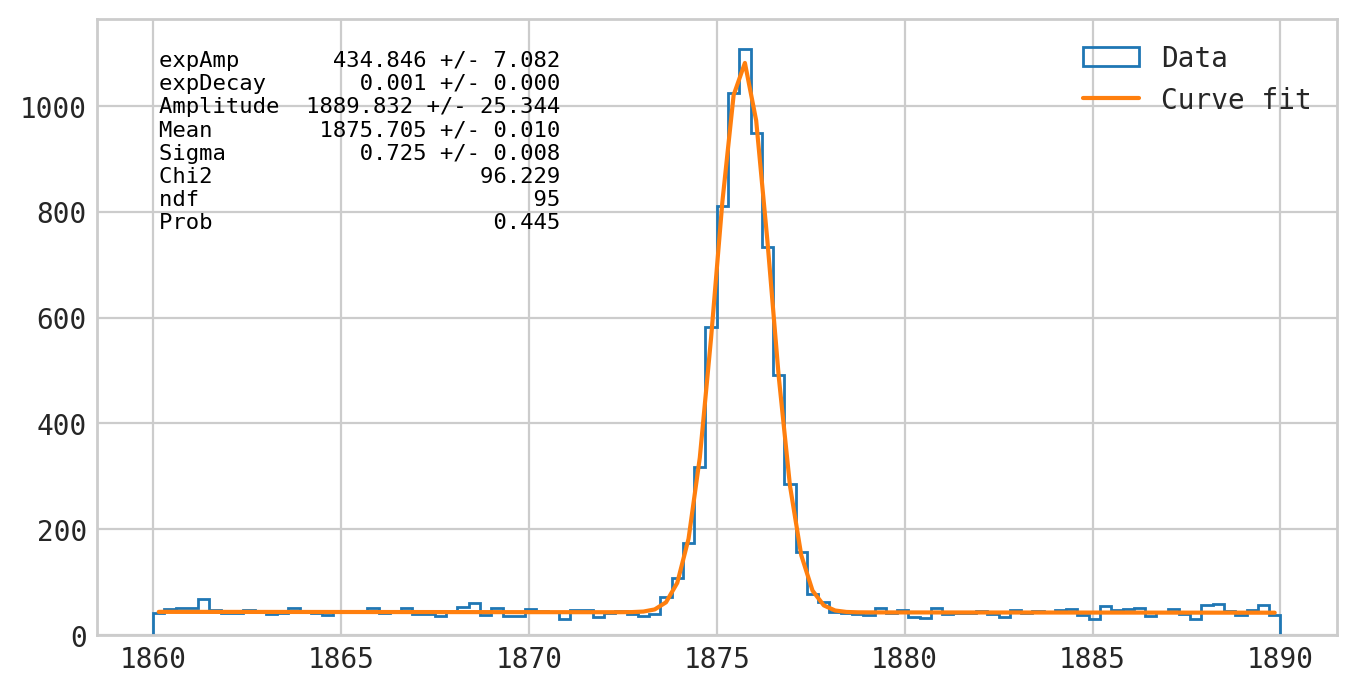

In [407]:
filtered_data = df2[(1860 < df2['Calibrated Wavelength']) & (df2['Calibrated Wavelength'] < 1890)]['Calibrated Wavelength']

Nbins = 100

y, x_edges = np.histogram(filtered_data, bins=Nbins)

x = (x_edges[1:] + x_edges[:-1])/2

chi2_object = Chi2Regression(fit_1_peak, x[y>0], y[y>0], np.sqrt(y)[y>0])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

minuit = Minuit(chi2_object, expAmp=2254, expDecay=0.001, amp=12258, mu=1875.6, sigma=2)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 5                   # Number of variables (expAmp, expDecay, amp, mu, sigma)
Ndof_fit = Nbins - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
plt.hist(filtered_data, bins=Nbins, histtype='step', label='Data')
plt.plot(x, fit_1_peak(x, minuit.values['expAmp'], minuit.values['expDecay'], minuit.values['amp'], 
         minuit.values['mu'], minuit.values['sigma']), label=f'Curve fit')
plt.legend()

d = {'expAmp': [minuit.values['expAmp'], minuit.errors['expAmp']],
     'expDecay': [minuit.values['expDecay'], minuit.errors['expDecay']],
     'Amplitude': [minuit.values['amp'], minuit.errors['amp']],
     'Mean': [minuit.values['mu'], minuit.errors['mu']],
     'Sigma': [minuit.values['sigma'], minuit.errors['sigma']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.05, 0.95, text, ax, fontsize=8)
